In [1]:
import pandas as pd
import os
import glob
from datetime import datetime

# 1. LOAD FILE LIST
# If you saved the CSV from the previous step:
# df = pd.read_csv("mea_file_locations.csv")

# OR, if you want to run it fresh right now:
root_search_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/"
files = glob.glob(os.path.join(root_search_path, "**", "*network*.json"), recursive=True)
df = pd.DataFrame(files, columns=['full_path'])

#ANCHOR = root_search_path.split(os.sep)[-3]  # anything before project name
ANCHOR = "AnalyzedData"
def parse_path_metadata(path):
    """
    Extracts metadata from the standard path structure:
    .../AnalyzedData/Genotype/Date/ChipID/Network/RunID/WellID/...
    """
    try:
        parts = path.split(os.sep)
        
        # We anchor everything relative to "AnalyzedData" to be safe
        if ANCHOR in parts:
            idx = parts.index(ANCHOR)

            # Extract based on your specific directory depth
            project = parts[idx + 1]  # e.g., CDKL5_T1
            date_str = parts[idx + 2]  # e.g., 240531
            chip_id  = parts[idx + 3]  # e.g., M07420
            # parts[idx + 4] is usually "Network"
            run_id   = parts[idx + 5]  # e.g., 000052
            well_id  = parts[idx + 6]  # e.g., well005
            
            return pd.Series([project, date_str, chip_id, run_id, well_id])
        else:
            return pd.Series([None, None, None, None, None])
            
    except IndexError:
        return pd.Series([None, None, None, None, None])

# 2. APPLY EXTRACTION
print(" dissecting path names...")
metadata_cols = ["Project", "Date", "Chip_ID", "RunID", "Well"]
df[metadata_cols] = df['full_path'].apply(parse_path_metadata)
#puth full_path to last column
df = df[[col for col in df.columns if col != 'full_path'] + ['full_path']]


# 4. REVIEW
print(f"Successfully dissected {len(df)} paths.")
print("\nSnapshot of extracted metadata:")
print(df.head())

# 5. SAVE
#df.to_csv("/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/mea_metadata_index_networks.csv", index=False)

 dissecting path names...
Successfully dissected 237 paths.

Snapshot of extracted metadata:
              Project    Date Chip_ID   RunID     Well  \
0  JGA_CSB3_010825_VD  250120  M05506  000017  well005   
1  JGA_CSB3_010825_VD  250120  M05506  000017  well003   
2  JGA_CSB3_010825_VD  250120  M05506  000017  well002   
3  JGA_CSB3_010825_VD  250120  M05506  000017  well000   
4  JGA_CSB3_010825_VD  250120  M05506  000017  well001   

                                           full_path  
0  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
1  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
2  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
3  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
4  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  


In [2]:
import json
import pandas as pd

# 1. Select the first file from our dissected dataframe
# We use .iloc[0] to grab the first row
sample_path = df.iloc[0]['full_path']
#print(f"Inspecting file: {sample_path}\n")
#sample_path = '/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1/240531/M07420/Network/000052/well004/network_results.json'
# 2. Load the JSON data
with open(sample_path, 'r') as f:
    data = json.load(f)

# 3. Helper function to print the structure without flooding the screen
# This will show you the Keys and the Type of data inside (e.g., float, list of 6000 items)
def print_structure(d, indent=0):
    spacing = "  " * indent
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, dict):
                print(f"{spacing}- {key}: (Nested Dictionary)")
                print_structure(value, indent + 1)
            elif isinstance(value, list):
                print(f"{spacing}- {key}: List [{len(value)} items]")
            else:
                print(f"{spacing}- {key}: {type(value).__name__} (e.g., {value})")
    else:
        print(f"{spacing} (Not a dictionary)")

# 4. Print the "Map" of your JSON
print("--- JSON FILE STRUCTURE ---")
print_structure(data)

# 5. Check for specific "Gold Mine" keys
# These are the standard keys usually found in MaxWell/MACS outputs.
# We try to print them specifically to see if they exist.
print("\n--- CHECKING FOR COMMON METRICS ---")
possible_keys = ['mean_firing_rate', 'mean_burst_rate', 'network_burst_frequency', 'burst_duration_mean']

found_metrics = {}
for key in possible_keys:
    # Check top level
    if key in data:
        found_metrics[key] = data[key]
    # Sometimes metrics are hidden inside a 'summary' or 'network' sub-dictionary
    elif 'summary' in data and key in data['summary']:
        found_metrics[key] = data['summary'][key]

print(f"Found specific metrics: {json.dumps(found_metrics, indent=2)}")

--- JSON FILE STRUCTURE ---
- burstlets: (Nested Dictionary)
  - events: List [359 items]
  - metrics: (Nested Dictionary)
    - count: int (e.g., 359)
    - rate: float (e.g., 1.1965366430181255)
    - duration: (Nested Dictionary)
      - mean: float (e.g., 0.24399442896932416)
      - std: float (e.g., 0.15904201358744133)
      - cv: float (e.g., 0.6518264136573243)
    - inter_event_interval: (Nested Dictionary)
      - mean: float (e.g., 0.8346871508378684)
      - std: float (e.g., 1.6661893456759824)
      - cv: float (e.g., 1.9961842517923545)
    - intensity: (Nested Dictionary)
      - mean: float (e.g., 13.920610259513694)
      - std: float (e.g., 9.628960928717568)
      - cv: float (e.g., 0.6917053742049056)
    - participation: (Nested Dictionary)
      - mean: float (e.g., 0.48209016816259165)
      - std: float (e.g., 0.18175060144021468)
      - cv: float (e.g., 0.3770054098653942)
    - spikes_per_burst: (Nested Dictionary)
      - mean: float (e.g., 672.90250696378

In [3]:
import json
import pandas as pd
import numpy as np
import os

# --- 1. SETUP & PROGRESS BAR ---
try:
    from tqdm import tqdm
    tqdm.pandas()
    # Assuming 'df' is your existing dataframe with file paths
    print("Progress bar enabled.")
except ImportError:
    def tqdm(x, **kwargs): return x
    print("Install 'tqdm' for a progress bar. Running standard loop...")
def extract_metrics(row):
    path = row['full_path']

    metrics = {
        # -------- Network Bursts (NB) --------
        "nb_count": np.nan,
        "nb_rate_hz": np.nan,
        "nb_duration_mean_s": np.nan,
        "nb_ibi_mean_s": np.nan,
        "nb_spikes_per_burst_mean": np.nan,
        "nb_participation_mean": np.nan,
        "nb_burst_peak_mean": np.nan,
        "nb_peak_synchrony_mean": np.nan,
        "nb_fragment_count_mean": np.nan,

        "nb_durations_list": [],
        "nb_peak_list": [],
        "nb_intensity_list": [],
        "nb_synchrony_energy_list": [],
        "nb_fragment_count_list": [],

        # -------- Superbursts (SB) --------
        "sb_count": np.nan,
        "sb_rate_hz": np.nan,
        "sb_duration_mean_s": np.nan,
        "sb_ibi_mean_s": np.nan,
        "sb_spikes_per_burst_mean": np.nan,
        "sb_participation_mean": np.nan,

        "sb_durations_list": [],
        "sb_peak_list": [],
        "sb_intensity_list": [],
        "sb_synchrony_energy_list": [],

        # -------- Burstlets (BL) --------
        "bl_count": np.nan,
        "bl_rate_hz": np.nan,
        "bl_duration_mean_s": np.nan,
        "bl_ibi_mean_s": np.nan,
        "bl_spikes_per_burst_mean": np.nan,
        "bl_participation_mean": np.nan,
        "bl_burst_peak_mean": np.nan,


        "bl_durations_list": [],
        "bl_peak_list": [],
        "bl_intensity_list": [],   
        "bl_synchrony_energy_list": [],
        "num_units": np.nan,
    }

    try:
        with open(path, "r") as f:
            data = json.load(f)

        # ---------- Helper ----------
        def extract_block(block, prefix):
            if block is None:
                return

            m = block.get("metrics", {})
            events = block.get("events", [])

            metrics[f"{prefix}_count"] = m.get("count", np.nan)

            if "rate" in m:
                metrics[f"{prefix}_rate_hz"] = m["rate"]

            metrics[f"{prefix}_duration_mean_s"] = m.get("duration", {}).get("mean")
            metrics[f"{prefix}_ibi_mean_s"] = m.get("inter_event_interval", {}).get("mean")
            metrics[f"{prefix}_spikes_per_burst_mean"] = m.get("spikes_per_burst", {}).get("mean")
            metrics[f"{prefix}_participation_mean"] = m.get("participation", {}).get("mean")
            metrics[f"{prefix}_burst_peak_mean"] = m.get("burst_peak", {}).get("mean")
            metrics[f"{prefix}_peak_synchrony_mean"] = m.get("peak_synchrony", {}).get("mean")

            # --- Raw Distributions ---
            for ev in events:
                if "duration_s" in ev:
                    metrics[f"{prefix}_durations_list"].append(ev["duration_s"])
                if "peak_synchrony" in ev:
                    metrics[f"{prefix}_peak_list"].append(ev["peak_synchrony"])
                if "synchrony_energy" in ev:
                    metrics[f"{prefix}_synchrony_energy_list"].append(ev["synchrony_energy"])
                if "total_spikes" in ev:
                    metrics[f"{prefix}_intensity_list"].append(ev["total_spikes"])
                if "fragment_count" in ev:
                    if "prefix" == "nb":
                        metrics[f"{prefix}_fragment_count_list"].append(ev["fragment_count"])
                        metrics[f"{prefix}_fragment_count_mean"] = np.mean(metrics[f"{prefix}_fragment_count_list"])
                
                
            

        # ---------- Apply ----------
        extract_block(data.get("network_bursts"), "nb")
        extract_block(data.get("superbursts"), "sb")
        extract_block(data.get("burstlets"), "bl")
        # Number of units
        metrics["num_units"] = data["n_units"]

    except Exception as e:
        print(f"[ERROR] {path}: {e}")

    return pd.Series(metrics)

# --- 3. RUN EXTRACTION ---
print("Starting unified extraction (Scalars + Lists)...")

# If you have tqdm installed, use progress_apply, otherwise use apply
if hasattr(tqdm, 'pandas'):
    df_metrics = df.progress_apply(extract_metrics, axis=1)
else:
    df_metrics = df.apply(extract_metrics, axis=1)

# Concatenate metadata with results
result_df = pd.concat([df, df_metrics], axis=1)



Progress bar enabled.
Starting unified extraction (Scalars + Lists)...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:02<00:00, 79.49it/s]


In [4]:
import pandas as pd

ref_df = pd.read_excel("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/JGA_CSB3_.xlsx")
print(ref_df.columns)

# --- 2. TRANSFORMATION LOGIC ---

# Step A: Split the strings into actual Python lists
ref_df['Wells_List'] = ref_df['Wells_Recorded'].astype(str).str.split(',')
ref_df['Source_List'] = ref_df['Neuron Source'].astype(str).str.split(',')

# Step B: Explode the lists into rows (keeps alignment)
exploded_df = ref_df.explode(['Wells_List', 'Source_List'])

# Step C: Cleanup
exploded_df['Well'] = exploded_df['Wells_List'].str.strip()
exploded_df['NeuronType'] = exploded_df['Source_List'].str.strip()

# Step D: FIX — convert 1-based wells to 0-based and format
exploded_df['Well'] = (
    'well'
    + (exploded_df['Well'].astype(int) - 1)
      .astype(str)
      .str.zfill(3)
)

# Filter to keep only the clean columns
clean_ref_df = exploded_df[['Date', 'ID', 'Run #', 'Well', 'NeuronType', 'Assay', 'DIV']]

# --- 3. VIEW RESULTS ---
print("Transformation complete.")
print(f"Original rows: {len(ref_df)}")
print(f"Exploded rows: {len(clean_ref_df)}")
print("\nFirst 10 rows of clean metadata:")
print(clean_ref_df.head(10))

# Save if needed
# clean_ref_df.to_csv("clean_metadata_map.csv", index=False)

Index(['Date', 'DIV', 'Assay', 'Run #', 'ID', 'Wells_Recorded',
       'Neuron Source'],
      dtype='object')
Transformation complete.
Original rows: 63
Exploded rows: 378

First 10 rows of clean metadata:
        Date      ID  Run #     Well    NeuronType          Assay  DIV
0 2025-01-15  M08018      1  well000  CSB3 Healthy      Full Scan    7
0 2025-01-15  M08018      1  well001  CSB3 Healthy      Full Scan    7
0 2025-01-15  M08018      1  well002  CSB3 Healthy      Full Scan    7
0 2025-01-15  M08018      1  well003  CSB3 Healthy      Full Scan    7
0 2025-01-15  M08018      1  well004  CSB3 Healthy      Full Scan    7
0 2025-01-15  M08018      1  well005  CSB3 Healthy      Full Scan    7
1 2025-01-15  M08018      2  well000  CSB3 Healthy  Network Today    7
1 2025-01-15  M08018      2  well001  CSB3 Healthy  Network Today    7
1 2025-01-15  M08018      2  well002  CSB3 Healthy  Network Today    7
1 2025-01-15  M08018      2  well003  CSB3 Healthy  Network Today    7


In [5]:
clean_ref_df.columns

Index(['Date', 'ID', 'Run #', 'Well', 'NeuronType', 'Assay', 'DIV'], dtype='object')

In [6]:
clean_ref_df['Date'] = (
    pd.to_datetime(clean_ref_df['Date'])
      .dt.strftime('%y%m%d')
)

/tmp/ipykernel_2564601/3958324485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ref_df['Date'] = (


In [7]:
result_df.columns

Index(['Project', 'Date', 'Chip_ID', 'RunID', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
       'nb_burst_peak_mean', 'nb_peak_synchrony_mean',
       'nb_fragment_count_mean', 'nb_durations_list', 'nb_peak_list',
       'nb_intensity_list', 'nb_synchrony_energy_list',
       'nb_fragment_count_list', 'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'sb_durations_list', 'sb_peak_list',
       'sb_intensity_list', 'sb_synchrony_energy_list', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
       'bl_burst_peak_mean', 'bl_durations_list', 'bl_peak_list',
       'bl_intensity_list', 'bl_synchrony_energy_list', 'num_units',
       'sb_burst_peak_mean', 'sb_peak_synchrony_mean',
       'bl_peak_synchrony_mean'],
      

In [8]:
result_df.rename(columns={"RunID": "Run #","Chip_ID": "ID"}, inplace=True)

In [9]:
result_df['Date'] = result_df['Date'].astype(str)

In [10]:
result_df['Run #'] = result_df['Run #'].astype(str).str.zfill(6)
clean_ref_df['Run #'] = clean_ref_df['Run #'].astype(str).str.zfill(6)

/tmp/ipykernel_2564601/2122106171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ref_df['Run #'] = clean_ref_df['Run #'].astype(str).str.zfill(6)


In [ ]:
print(result_df['Well'].unique()[:10])
print(clean_ref_df['Well'].unique()[:10])



['well005' 'well003' 'well002' 'well000' 'well001' 'well004']
['well000' 'well001' 'well002' 'well003' 'well004' 'well005']


In [13]:
# JSON-derived table must be unique
assert not result_df.duplicated(
    ['ID','Date','Run #','Well']
).any(), "Duplicate JSON-derived rows detected"

# Metadata table must be unique
assert not clean_ref_df.duplicated(
    ['ID','Date','Run #','Well']
).any(), "Duplicate metadata rows detected"

In [14]:
merged_df = pd.merge(
    result_df,
    clean_ref_df,
    how='left',
    on=['ID', 'Date', 'Run #', 'Well'],
    validate='one_to_one'
)

In [15]:
#order by run #
merged_df.sort_values(by=['ID', 'Run #', 'Well'], inplace=True)

In [16]:
merged_df.head()

,Project,Date,ID,Run #,Well,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,...,bl_peak_list,bl_intensity_list,bl_synchrony_energy_list,num_units,sb_burst_peak_mean,sb_peak_synchrony_mean,bl_peak_synchrony_mean,NeuronType,Assay,DIV
71,JGA_CSB3_010825_VD,250115,M05506,000008,well000,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,16.0,0.053327,0.560625,16.370000,...,"[5.737272000192839, 5.148369055485264, 5.03342...","[78, 51, 57, 61, 50, 63, 93, 81, 73, 65, 58, 6...","[1.6363156975286546, 1.1200023968808417, 1.463...",28,NaN,NaN,5.637979,CSB3 E200K,Network Today,7.0
72,JGA_CSB3_010825_VD,250115,M05506,000008,well001,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,41.0,0.136682,0.779268,7.289250,...,"[12.514640008036434, 12.664347141800697, 14.62...","[152, 85, 131, 103, 77, 83, 162, 112, 73, 382,...","[3.0427212429805537, 1.79058043800414, 3.30841...",62,NaN,NaN,12.938829,CSB3 E200K,Network Today,7.0
70,JGA_CSB3_010825_VD,250115,M05506,000008,well002,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,99.0,0.329965,0.509091,3.004898,...,"[10.554352198537021, 11.558724772569722, 11.05...","[125, 126, 75, 191, 124, 99, 107, 104, 53, 274...","[2.5315143425685283, 2.765928471539953, 1.8795...",88,NaN,NaN,11.864242,CSB3 E200K,Network Today,7.0
69,JGA_CSB3_010825_VD,250115,M05506,000008,well003,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,28.0,0.093329,0.418929,10.703689,...,"[5.115846619053557, 7.20124863628066, 5.610308...","[36, 58, 47, 69, 68, 39, 45, 53, 52, 140, 68, ...","[0.8773028269551432, 1.0498776252084978, 0.948...",30,NaN,NaN,5.853816,CSB3 E200K,Network Today,7.0
73,JGA_CSB3_010825_VD,250115,M05506,000008,well004,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,53.0,0.176653,0.494151,5.603077,...,"[15.443775962886098, 11.291412772828348, 10.31...","[213, 92, 108, 144, 100, 74, 115, 87, 91, 140,...","[5.142542612980335, 2.3908927941346247, 2.6183...",76,NaN,NaN,11.950298,CSB3 E200K,Network Today,7.0


In [17]:
merged_df['Date'].dtype

dtype('O')

In [18]:
plating_date = '250108'
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%y%m%d')
plating_date_dt = pd.to_datetime(plating_date, format='%y%m%d')
merged_df['DIV'] = (merged_df['Date'] - plating_date_dt).dt.days

In [19]:
merged_df.columns

Index(['Project', 'Date', 'ID', 'Run #', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
       'nb_burst_peak_mean', 'nb_peak_synchrony_mean',
       'nb_fragment_count_mean', 'nb_durations_list', 'nb_peak_list',
       'nb_intensity_list', 'nb_synchrony_energy_list',
       'nb_fragment_count_list', 'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'sb_durations_list', 'sb_peak_list',
       'sb_intensity_list', 'sb_synchrony_energy_list', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
       'bl_burst_peak_mean', 'bl_durations_list', 'bl_peak_list',
       'bl_intensity_list', 'bl_synchrony_energy_list', 'num_units',
       'sb_burst_peak_mean', 'sb_peak_synchrony_mean',
       'bl_peak_synchrony_mean', 'NeuronType'

In [20]:
merged_df.to_excel("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/mea_combined_metrics.xlsx", index=False)

In [21]:
#delete rows where DIV is NaN
merged_df = merged_df.dropna(subset=['DIV'])

In [22]:
merged_df['Assay'].unique()    

array(['Network Today', 'Neuronal Units 9', nan], dtype=object)

In [23]:
#split merged_df into two dataframes based on Assay type
network_assay_df = merged_df[merged_df['Assay'] == 'Network today']
neuronal_assay_df = merged_df[merged_df['Assay'] == 'Neuronal Units 9']
#neuronal_assay_df = merged_df[merged_df['Assay'] == 'Neuronal unit']

In [30]:
#delete DIV ==26
neuronal_assay_df = neuronal_assay_df[neuronal_assay_df['DIV'] != 26]

In [31]:
neuronal_assay_df.head()

,Project,Date,ID,Run #,Well,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,...,bl_peak_list,bl_intensity_list,bl_synchrony_energy_list,num_units,sb_burst_peak_mean,sb_peak_synchrony_mean,bl_peak_synchrony_mean,NeuronType,Assay,DIV
77,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well000,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,28.0,0.093465,0.588214,10.348889,...,"[5.2476917665725225, 6.862817079551998, 5.8010...","[55, 91, 96, 63, 76, 88, 68, 72, 38, 52, 71, 7...","[1.1823018811070998, 1.8553284956307556, 2.407...",27,NaN,NaN,5.908215,CSB3 E200K,Neuronal Units 9,7
78,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well001,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,39.0,0.129986,0.612308,7.836316,...,"[10.96627712073074, 12.976180434227798, 17.183...","[152, 81, 147, 77, 79, 80, 113, 150, 102, 112,...","[2.8859639443734757, 2.1993284629264, 3.042084...",53,NaN,NaN,12.292548,CSB3 E200K,Neuronal Units 9,7
76,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well002,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,137.0,0.456626,0.498531,2.175400,...,"[11.65016649671894, 12.143127482933279, 10.630...","[115, 143, 131, 100, 80, 154, 188, 88, 73, 53,...","[2.460674305598296, 3.4175974052200297, 2.6928...",73,NaN,NaN,11.756068,CSB3 E200K,Neuronal Units 9,7
75,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well003,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,44.0,0.146660,0.388500,6.787607,...,"[5.7299310733083235, 5.1558524674546335, 5.868...","[64, 32, 43, 81, 37, 40, 30, 59, 51, 45, 36, 4...","[1.4011445141446062, 0.6922616525969291, 0.734...",29,NaN,NaN,5.894634,CSB3 E200K,Neuronal Units 9,7
79,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well004,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,14.0,0.046667,0.505714,20.162308,...,"[11.67843413313554, 12.621342730901826, 10.663...","[143, 210, 93, 120, 169, 63, 174, 57, 114, 226...","[3.1777784465503527, 4.673072637484475, 2.3089...",61,NaN,NaN,11.445799,CSB3 E200K,Neuronal Units 9,7


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind


def plot_scalar_line_ttest_vs_control(
    df,
    value_col,
    control_group='MxWT',
    feature_label=None,
    order=('MxWT', 'FxHET', 'MxHEMI'),
    palette={'MxWT': '#1f77b4', 'FxHET': '#c77b1b', 'MxHEMI': '#d62728'},
    save_path=None
):
    """
    Lineplot comparing groups vs control.

    ASSUMPTION (CRITICAL):
    - Each row = one well (biological replicate) at one DIV
    - No technical replicates inside a well
    """
    DIV_to_exclude =[]
    # ------------------------------------------------------------
    # 0. X-AXIS GEOMETRY CONTROL
    # ------------------------------------------------------------
    DIV_SPACING  = 1.6    # spacing between DIVs
    GENO_SPACING = 0.15   # spacing between genotypes within DIV

    # ------------------------------------------------------------
    # 1. PREP DATA (NO AGGREGATION HERE)
    # ------------------------------------------------------------
    req_cols = {'DIV', 'NeuronType', 'ID', 'Well', value_col}
    missing = req_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    sub = df[list(req_cols)].copy()
    sub = sub.dropna(subset=[value_col])

    # unique biological replicate ID (for sanity checks only)
    sub['ChipID_Well'] = sub['ID'].astype(str) + '_W' + sub['Well'].astype(str)

    # ------------------------------------------------------------
    # 1a. SANITY CHECKS (FAIL FAST)
    # ------------------------------------------------------------
    # dup_check = (
    #     sub.groupby(['DIV', 'ChipID_Well', 'NeuronType'])
    #     .size()
    #     .reset_index(name='n')
    # )

    # if (dup_check['n'] > 1).any():
    #     raise RuntimeError(
    #         "Multiple rows detected per (DIV, ChipID_Well, NeuronType).\n"
    #         "You are double-counting replicates.\n"
    #         "Either aggregate explicitly OR fix upstream data."
    #     )

    # ------------------------------------------------------------
    # 2. SUMMARY STATS (BIOLOGICAL REPLICATES ONLY)
    # ------------------------------------------------------------
    summary = (
        sub
        .groupby(['DIV', 'NeuronType'], as_index=False)
        .agg(
            mean_value=(value_col, 'mean'),
            sem_value=(value_col, lambda x: sem(x, nan_policy='omit')),
            n_wells=(value_col, 'count')
        )
    )

    divs = sorted(summary['DIV'].unique())
    if DIV_to_exclude:
        divs = [d for d in divs if d not in DIV_to_exclude]
    # categorical x positions
    div_to_x = {div: i * DIV_SPACING for i, div in enumerate(divs)}

    # genotype offsets
    group_offsets = {
        g: (i - (len(order) - 1) / 2) * GENO_SPACING
        for i, g in enumerate(order)
    }

    # ------------------------------------------------------------
    # 3. ROBUST Y LIMITS (DISPLAY ONLY)
    # ------------------------------------------------------------
    yvals = sub[value_col].values
    yvals = yvals[np.isfinite(yvals)]

    if yvals.size < 2:
        print(f"[SKIP] {value_col}: insufficient finite data")
        return


    y_low = np.nanpercentile(yvals, 1)
    y_high = np.nanpercentile(yvals, 99)

    if not np.isfinite(y_low) or not np.isfinite(y_high):
        print(f"[SKIP] {value_col}: invalid y-limits")
        return

    if y_high <= y_low:
        # flat or near-flat feature
        pad = 0.1 * (abs(y_high) if y_high != 0 else 1.0)
        y_low -= pad
        y_high += pad

    yrange = y_high - y_low
    # ------------------------------------------------------------
    # 4. FIGURE
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 4.8))
    ax.set_ylim(y_low, y_high + 0.05 * yrange)

    # ------------------------------------------------------------
    # 5. SCATTER + LOLLIPOP OUTLIERS (RAW DATA)
    # ------------------------------------------------------------
    for nt in order:
        if nt not in palette:
            continue

        sub_nt = sub[sub['NeuronType'] == nt]
        offset = group_offsets[nt]
        jitter = (np.random.rand(len(sub_nt)) - 0.5) * 0.12

        x = sub_nt['DIV'].map(div_to_x) + offset + jitter
        y = sub_nt[value_col]

        mask_in = y <= y_high
        mask_out = y > y_high

        ax.scatter(
            x[mask_in],
            y[mask_in],
            s=18,
            alpha=0.25,
            color=palette[nt],
            edgecolor='none',
            zorder=1
        )

        if mask_out.any():
            ax.scatter(
                x[mask_out],
                np.full(mask_out.sum(), y_high),
                marker='^',
                s=40,
                color=palette[nt],
                alpha=0.85,
                zorder=4
            )

    # ------------------------------------------------------------
    # 6. MEAN ± SEM LINES
    # ------------------------------------------------------------
    for nt in order:
        if nt not in palette:
            continue

        sub_nt = summary[summary['NeuronType'] == nt]
        x = sub_nt['DIV'].map(div_to_x) + group_offsets[nt]

        ax.plot(
            x,
            sub_nt['mean_value'],
            '-o',
            lw=2.5,
            color=palette[nt],
            label=nt,
            zorder=3
        )

        ax.fill_between(
            x,
            sub_nt['mean_value'] - sub_nt['sem_value'],
            sub_nt['mean_value'] + sub_nt['sem_value'],
            color=palette[nt],
            alpha=0.12,
            zorder=2
        )

    # ------------------------------------------------------------
    # 7. STATS (WELL-LEVEL, WT VS MUTANTS)
    # ------------------------------------------------------------
    sig_results = []

    for div in divs:
        day_data = sub[sub['DIV'] == div]

        ctrl = day_data[
            day_data['NeuronType'] == control_group
        ][value_col]

        if len(ctrl) < 2:
            continue

        for group in order:
            if group == control_group:
                continue

            exp = day_data[
                day_data['NeuronType'] == group
            ][value_col]

            if len(exp) < 2:
                continue

            _, p = ttest_ind(
                ctrl, exp,
                equal_var=False,
                nan_policy='omit'
            )

            if p < 0.05:
                sig_results.append((div, group, p))

    # ------------------------------------------------------------
    # 8. INLINE SIGNIFICANCE STARS
    # ------------------------------------------------------------
    for div, group, p in sig_results:
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*'

        y = summary[
            (summary['DIV'] == div) &
            (summary['NeuronType'] == group)
        ]['mean_value'].values

        if len(y) == 0:
            continue

        x = div_to_x[div] + group_offsets[group]
        y0 = y[0]
        dy = yrange * 0.035

        ax.plot([x, x], [y0, y0 + dy * 0.8], lw=1, color='k', zorder=4)
        ax.text(
            x, y0 + dy, sig,
            ha='center', va='bottom',
            fontsize=12, fontweight='bold',
            color='k', zorder=5
        )

    # ------------------------------------------------------------
    # 9. FINAL POLISH
    # ------------------------------------------------------------
    ax.set_xlabel('Days In Vitro (DIV)', weight='bold')
    ax.set_ylabel(feature_label or value_col, weight='bold')

    ax.set_xticks([div_to_x[d] for d in divs])
    ax.set_xticklabels(divs)

    ax.legend(
        title='Genotype',
        frameon=False,
        loc='upper left',
        bbox_to_anchor=(1, 1)
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    if save_path:
        dir = os.path.dirname(save_path)
        os.makedirs(dir, exist_ok=True)
        plt.savefig(save_path, dpi=300, format='svg')
    plt.show()

In [26]:
neuronal_assay_df.columns

Index(['Project', 'Date', 'ID', 'Run #', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
       'nb_burst_peak_mean', 'nb_peak_synchrony_mean',
       'nb_fragment_count_mean', 'nb_durations_list', 'nb_peak_list',
       'nb_intensity_list', 'nb_synchrony_energy_list',
       'nb_fragment_count_list', 'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'sb_durations_list', 'sb_peak_list',
       'sb_intensity_list', 'sb_synchrony_energy_list', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
       'bl_burst_peak_mean', 'bl_durations_list', 'bl_peak_list',
       'bl_intensity_list', 'bl_synchrony_energy_list', 'num_units',
       'sb_burst_peak_mean', 'sb_peak_synchrony_mean',
       'bl_peak_synchrony_mean', 'NeuronType'

In [27]:
neuronal_assay_df['NeuronType'].unique()

array(['CSB3 E200K', 'CSB3 Healthy', 'CSB3 E198K'], dtype=object)

In [ ]:
cols_to_plot = [ 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s','nb_fragment_count_mean',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
     'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
        'num_units'
       ]
for col in cols_to_plot:
    plot_scalar_line_ttest_vs_control(
        network_assay_df,
        value_col=col,
        feature_label=col.replace('_', ' ').title(),
        order=( 'Healthy', 'E198K', 'E200K'),
        palette={ 'Healthy': 'black','E198K': '#ff7f0e', 'E200K': 'cornflowerblue'},
        #save_path=f"/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/plots/{col}_lineplot.svg"
    )


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import sem, ttest_ind, levene
from itertools import combinations

def analyze_organoid_pairwise_final(
    df,
    value_col,
    order=('Healthy', 'E198K', 'E200K'),
    palette={'Healthy': 'black', 'E198K': '#ff7f0e', 'E200K': 'cornflowerblue'},
    feature_label=None,
    save_path=None
):
    """
    Standardized HD-MEA Analysis for Organoids:
    - Auto-selects Student/Welch T-test per comparison.
    - Publication-quality brackets (no messy text on plots).
    - Robust error handling for NaN/Zero-variance data.
    """
    
    # 1. DATA PREP & CLEANING
    sub = df[['DIV', 'NeuronType', value_col]].copy().dropna(subset=[value_col])
    
    # Handle entirely empty columns
    if sub.empty:
        print(f"[SKIP] {value_col}: No data points found.")
        return

    divs = sorted(sub['DIV'].unique())

    # 2. SUMMARY TABLE (Mean, SEM, N)
    summary = sub.groupby(['DIV', 'NeuronType']).agg(
        mean=(value_col, 'mean'),
        sem=(value_col, lambda x: sem(x, nan_policy='omit')),
        n=(value_col, 'count')
    ).reindex(order, level='NeuronType').reset_index()

    # 3. PAIRWISE STATS WITH AUTO-SELECTION (Student vs Welch)
    stats_list = []
    pairs = list(combinations(order, 2))

    def get_stars(p):
        if p < 0.001: return '***'
        if p < 0.01: return '**'
        if p < 0.05: return '*'
        return None

    for div in divs:
        day_data = sub[sub['DIV'] == div]
        for g1, g2 in pairs:
            v1 = day_data[day_data['NeuronType'] == g1][value_col].values
            v2 = day_data[day_data['NeuronType'] == g2][value_col].values

            if len(v1) >= 2 and len(v2) >= 2:
                # Levene's test to check variance equality
                _, p_lev = levene(v1, v2)
                equal_var = p_lev > 0.05
                test_type = "Student" if equal_var else "Welch"

                # Run appropriate T-test
                _, p = ttest_ind(v1, v2, equal_var=equal_var, nan_policy='omit')
                
                stats_list.append({
                    'DIV': div, 'G1': g1, 'G2': g2, 'Comparison': f"{g1} vs {g2}",
                    'p_raw': p, 'test_used': test_type, 'sig': get_stars(p)
                })
            else:
                stats_list.append({
                    'DIV': div, 'G1': g1, 'G2': g2, 'Comparison': f"{g1} vs {g2}",
                    'p_raw': np.nan, 'test_used': 'N<2', 'sig': None
                })

    stats_df = pd.DataFrame(stats_list)

    # 4. PLOTTING WITH ROBUST LIMITS
    fig, ax = plt.subplots(figsize=(10, 6))
    DIV_SPACING, GENO_SPACING = 2.0, 0.3
    div_to_x = {d: i * DIV_SPACING for i, d in enumerate(divs)}
    offsets = {g: (i - (len(order)-1)/2) * GENO_SPACING for i, g in enumerate(order)}

    # --- CRITICAL: Robust Y-Limit Logic to prevent NaN/Inf Errors ---
    yvals = sub[value_col].dropna().values
    yvals = yvals[np.isfinite(yvals)]
    
    if len(yvals) == 0:
        print(f"[SKIP] {value_col}: No finite values to plot.")
        plt.close(fig)
        return

    y_l, y_h = np.nanpercentile(yvals, 1), np.nanpercentile(yvals, 99)
    yr = (y_h - y_l)
    
    # If data is flat, create a dummy range
    if yr == 0:
        yr = abs(y_h) * 0.1 if y_h != 0 else 1.0
        
    if not np.isfinite(y_l) or not np.isfinite(y_h):
        print(f"[SKIP] {value_col}: Calculation resulted in non-finite limits.")
        plt.close(fig)
        return

    ax.set_ylim(y_l - 0.15 * yr, y_h + 0.8 * yr)

    # 5. DRAW DATA
    for nt in order:
        d_nt = sub[sub['NeuronType'] == nt]
        s_nt = summary[summary['NeuronType'] == nt]
        
        # Jittered Raw Points
        x_raw = d_nt['DIV'].map(div_to_x) + offsets[nt] + (np.random.rand(len(d_nt))-0.5)*0.1
        ax.scatter(x_raw, d_nt[value_col], color=palette[nt], alpha=0.15, s=25, zorder=1)
        
        # Mean & SEM Line
        x_m = s_nt['DIV'].map(div_to_x) + offsets[nt]
        ax.plot(x_m, s_nt['mean'], '-o', color=palette[nt], label=nt, lw=2.5, zorder=3)
        ax.fill_between(x_m, s_nt['mean']-s_nt['sem'], s_nt['mean']+s_nt['sem'], 
                        color=palette[nt], alpha=0.1, zorder=2)

    # 6. DRAW SIGNIFICANCE BRACKETS
    for div in divs:
        div_sig = stats_df[(stats_df['DIV'] == div) & (stats_df['sig'].notna())]
        
        # Determine starting height for brackets at this DIV
        y_max_at_div = summary[summary['DIV'] == div].apply(lambda x: x['mean'] + x['sem'], axis=1).max()
        # Ensure brackets are at least above the local data points
        y_start = max(y_max_at_div + 0.05 * yr, y_l + 0.1 * yr)

        for i, (_, row) in enumerate(div_sig.iterrows()):
            x1 = div_to_x[div] + offsets[row['G1']]
            x2 = div_to_x[div] + offsets[row['G2']]
            
            # Increment Y height for multiple brackets
            y = y_start + (i * 0.15 * yr)
            h = 0.03 * yr # bracket tick height
            
            # Drawing
            ax.plot([x1, x1, x2, x2], [y-h, y, y, y-h], lw=1.2, color='#444444')
            ax.text((x1+x2)/2, y + 0.01*yr, row['sig'], ha='center', va='bottom', 
                    fontsize=12, fontweight='bold', color='black')

    # 7. FINAL POLISH
    ax.set_xticks([div_to_x[d] for d in divs])
    ax.set_xticklabels(divs)
    ax.set_xlabel('Days In Vitro (DIV)', fontweight='bold')
    ax.set_ylabel(feature_label or value_col, fontweight='bold')
    ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    ax.spines[['top', 'right']].set_visible(False)
    
    # 8. CONSOLE OUTPUT
    print(f"\n{'='*60}\nFEATURE: {value_col}\n{'='*60}")
    print("\n[SUMMARY TABLE]")
    print(summary[['DIV', 'NeuronType', 'n', 'mean', 'sem']].to_string(index=False))
    print("\n[STATISTICAL LOG: Student/Welch Selection]")
    print(stats_df[['DIV', 'Comparison', 'test_used', 'p_raw', 'sig']].dropna(subset=['p_raw']).to_string(index=False))

    plt.tight_layout()
    if save_path: 
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.show()
    return fig



FEATURE: nb_count

[SUMMARY TABLE]
 DIV   NeuronType  n       mean       sem
   7 CSB3 Healthy  5  50.400000 16.338911
   7   CSB3 E198K  6  25.833333  2.344023
   7   CSB3 E200K  6  46.333333 18.780605
  12 CSB3 Healthy  5  74.200000 24.757625
  12   CSB3 E198K  6  23.000000  1.712698
  12   CSB3 E200K  6  59.833333  6.488023
  14 CSB3 Healthy  5 146.800000 34.156112
  14   CSB3 E198K  6  23.333333  1.085255
  14   CSB3 E200K  6  85.666667 16.130027
  19 CSB3 Healthy  5 146.000000 59.841457
  19   CSB3 E198K  6  19.833333  1.492574
  19   CSB3 E200K  6  53.500000 10.180864
  21 CSB3 Healthy  5  93.600000 28.408801
  21   CSB3 E198K  6  23.666667  0.918937
  21   CSB3 E200K  6  61.166667  9.586159
  26 CSB3 Healthy  5  36.800000  5.314132
  26   CSB3 E198K  6  21.666667  1.256096
  28 CSB3 Healthy  5 128.400000 38.268264
  28   CSB3 E198K  6  22.000000  1.770122
  28   CSB3 E200K  6  31.666667  6.119187

[STATISTICAL LOG: Student/Welch Selection]
 DIV                 Comparison test_u

/tmp/ipykernel_1217550/1783395197.py:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem=(value_col, lambda x: sem(x, nan_policy='omit')),
/tmp/ipykernel_1217550/1783395197.py:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem=(value_col, lambda x: sem(x, nan_policy='omit')),
/tmp/ipykernel_1217550/1783395197.py:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem=(value_col, lambda x: sem(x, nan_policy='omit')),



FEATURE: sb_duration_mean_s

[SUMMARY TABLE]
 DIV   NeuronType  n     mean      sem
   7 CSB3 Healthy  1 3.772500      NaN
   7   CSB3 E198K  4 2.864750 0.144057
  12 CSB3 Healthy  3 2.844619 0.057796
  12   CSB3 E198K  6 3.444286 0.390710
  12   CSB3 E200K  4 2.746025 0.107106
  14 CSB3 Healthy  3 2.986546 0.121161
  14   CSB3 E198K  6 3.411229 0.335507
  14   CSB3 E200K  4 2.792002 0.145367
  19 CSB3 Healthy  3 3.476529 0.508935
  19   CSB3 E198K  5 3.002150 0.175324
  19   CSB3 E200K  6 3.116087 0.243523
  21 CSB3 Healthy  3 3.184853 0.250411
  21   CSB3 E198K  4 2.815106 0.113067
  21   CSB3 E200K  5 3.162628 0.378035
  26 CSB3 Healthy  5 3.096558 0.154339
  26   CSB3 E198K  3 2.828333 0.216852
  28 CSB3 Healthy  2 3.610417 0.409583
  28   CSB3 E198K  3 2.987173 0.211327
  28   CSB3 E200K  6 3.416600 0.219962

[STATISTICAL LOG: Student/Welch Selection]
 DIV                 Comparison test_used    p_raw  sig
  12 CSB3 Healthy vs CSB3 E198K   Student 0.330248 None
  12 CSB3 Healthy 

/tmp/ipykernel_1217550/1783395197.py:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem=(value_col, lambda x: sem(x, nan_policy='omit')),
/tmp/ipykernel_1217550/1783395197.py:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem=(value_col, lambda x: sem(x, nan_policy='omit')),
/tmp/ipykernel_1217550/1783395197.py:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem=(value_col, lambda x: sem(x, nan_policy='omit')),



FEATURE: bl_count

[SUMMARY TABLE]
 DIV   NeuronType  n       mean       sem
   7 CSB3 Healthy  5 138.400000 50.836601
   7   CSB3 E198K  6 138.166667 27.351315
   7   CSB3 E200K  6  92.666667 42.162912
  12 CSB3 Healthy  5 256.000000 75.572482
  12   CSB3 E198K  6 234.666667 33.795134
  12   CSB3 E200K  6 408.000000 54.144867
  14 CSB3 Healthy  5 426.400000 97.989591
  14   CSB3 E198K  6 261.833333 28.892233
  14   CSB3 E200K  6 548.500000 65.436356
  19 CSB3 Healthy  5 413.800000 76.227554
  19   CSB3 E198K  6 199.666667 25.528633
  19   CSB3 E200K  6 481.000000 38.748763
  21 CSB3 Healthy  5 332.000000 61.349002
  21   CSB3 E198K  6 216.833333 31.807145
  21   CSB3 E200K  6 497.833333 48.419291
  26 CSB3 Healthy  5 209.400000 71.812673
  26   CSB3 E198K  6 219.333333 16.837788
  28 CSB3 Healthy  5 327.000000 62.275196
  28   CSB3 E198K  6 187.166667 30.669656
  28   CSB3 E200K  6 404.666667 35.051074

[STATISTICAL LOG: Student/Welch Selection]
 DIV                 Comparison test_u

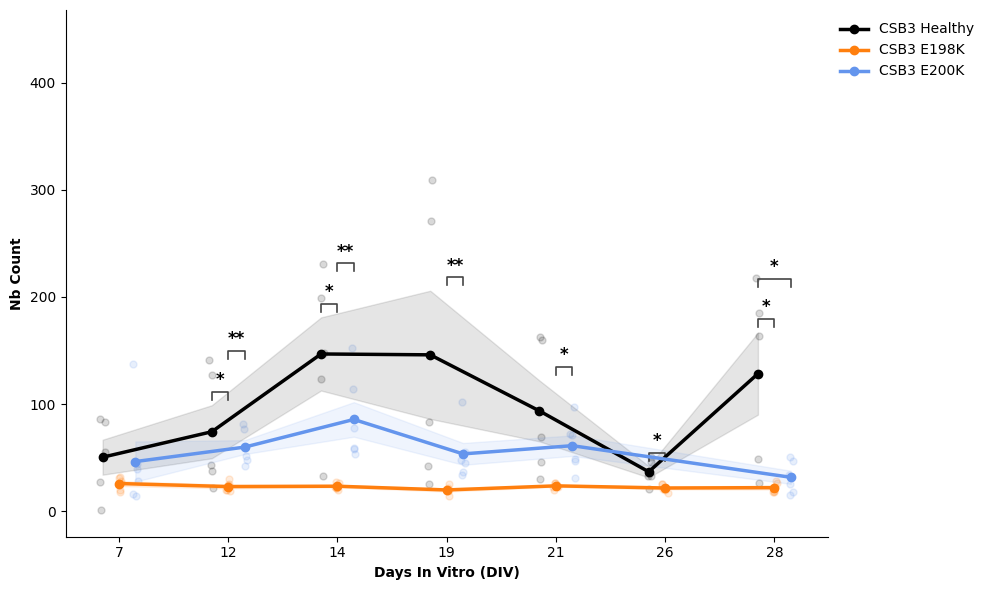

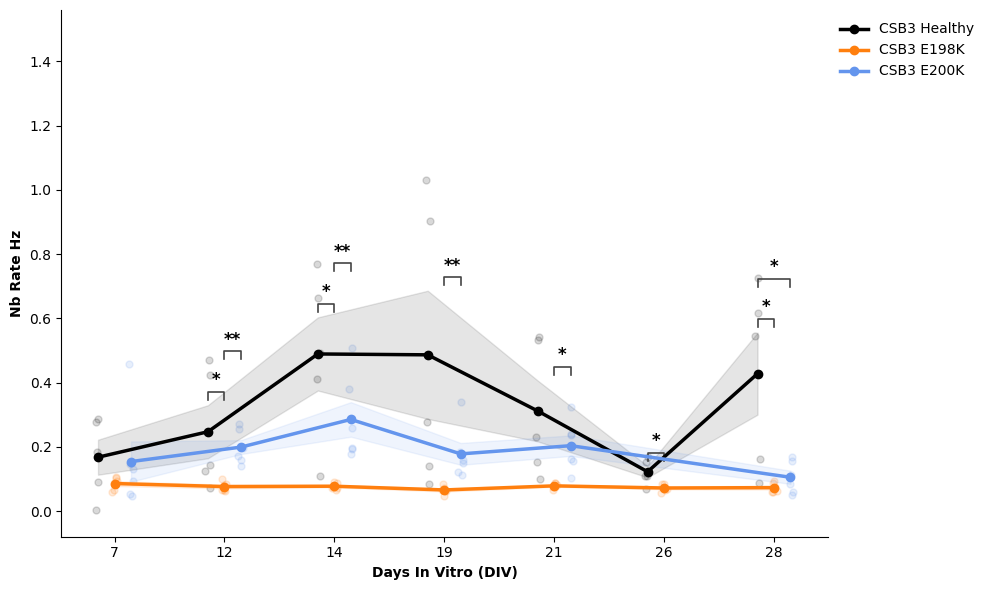

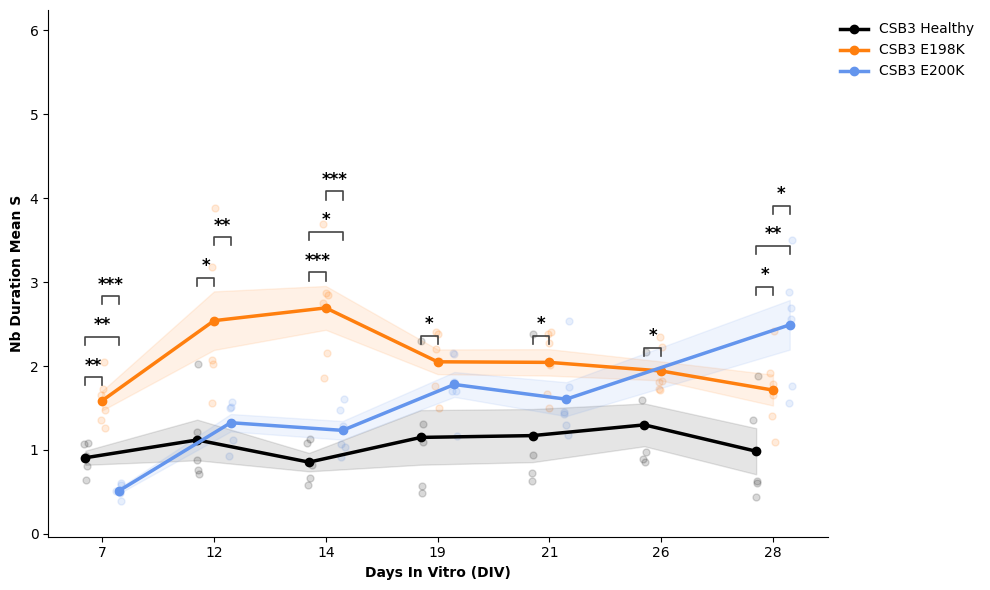

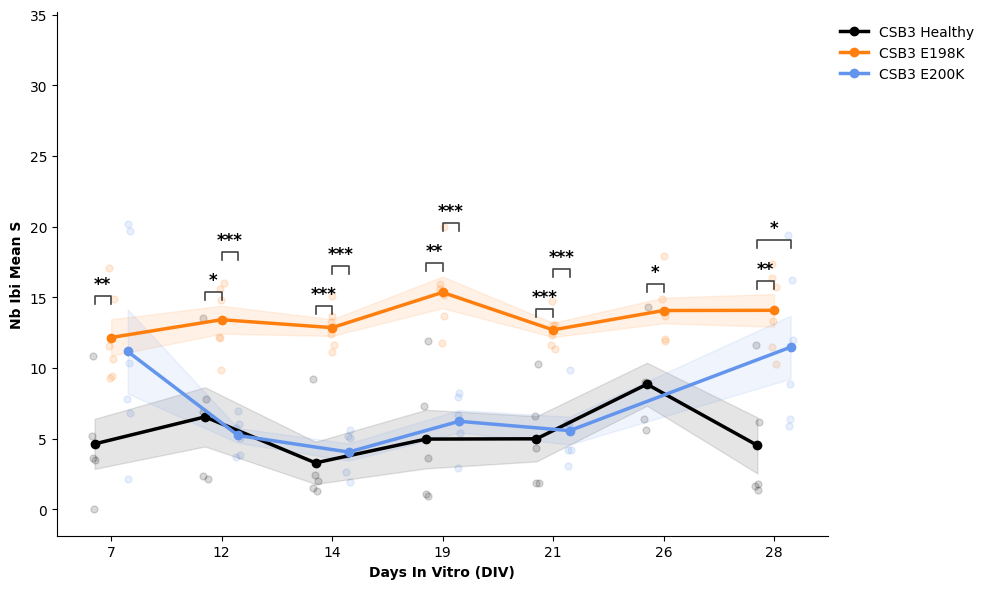

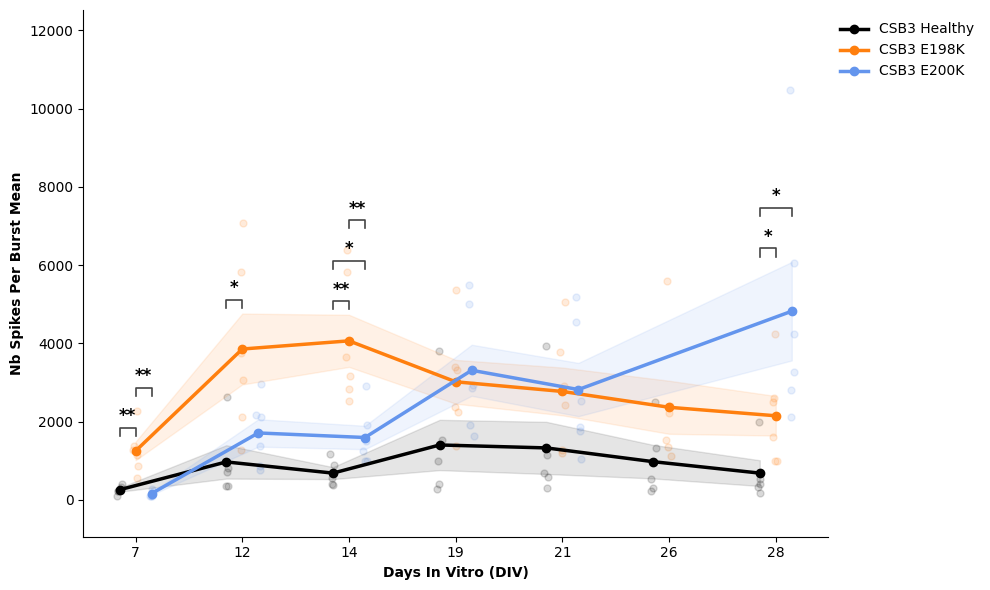

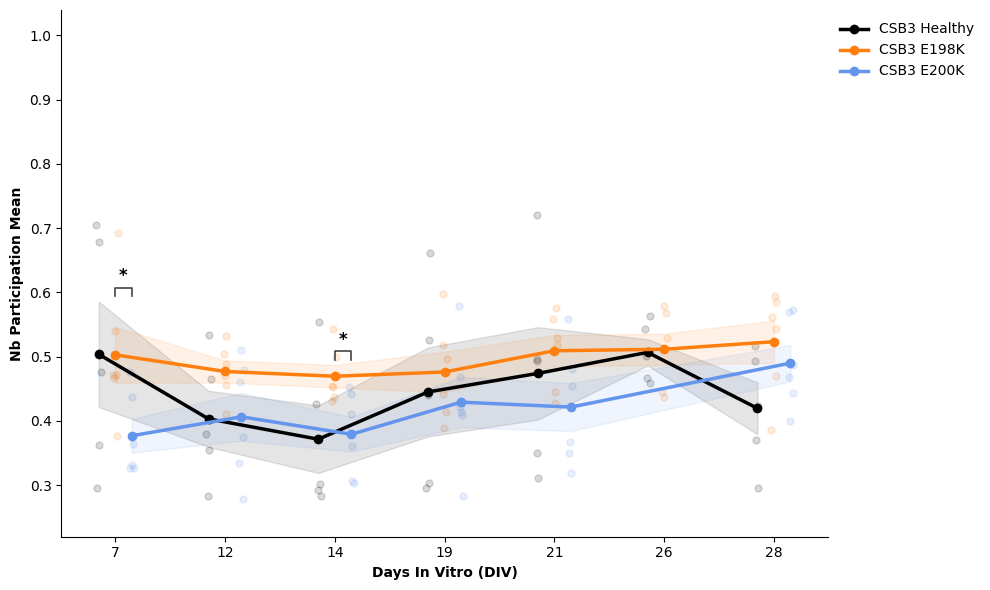

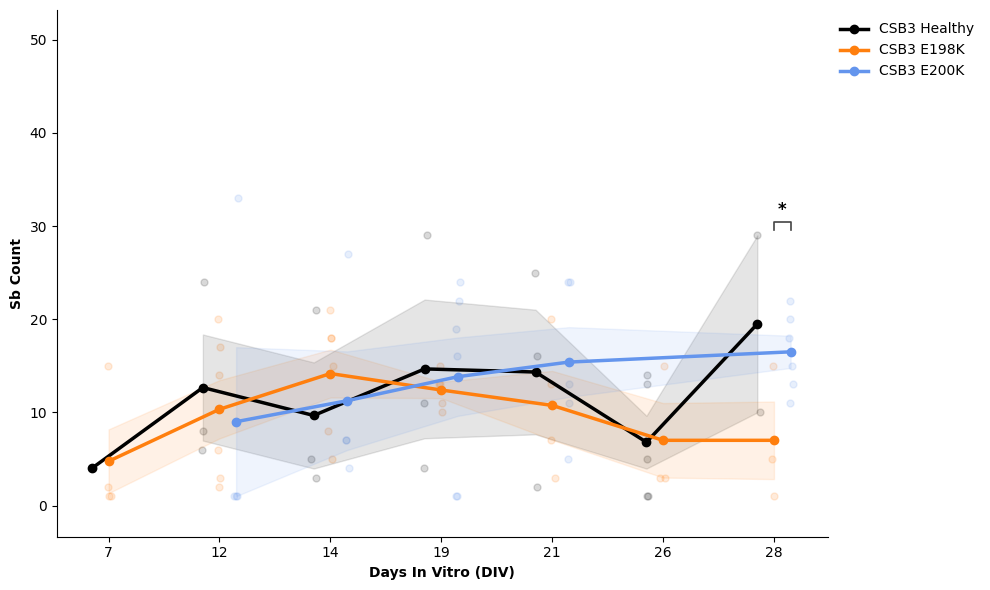

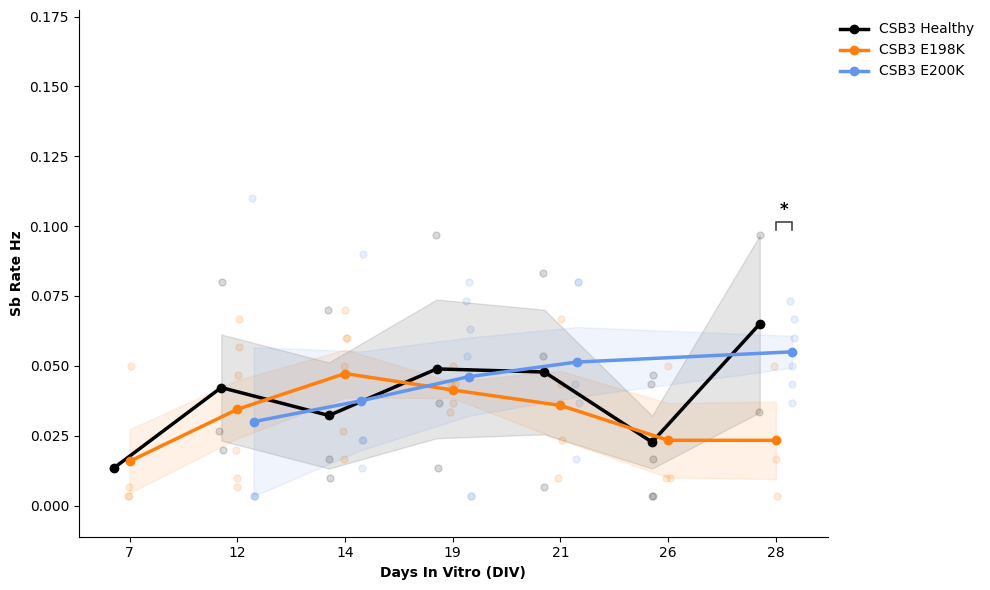

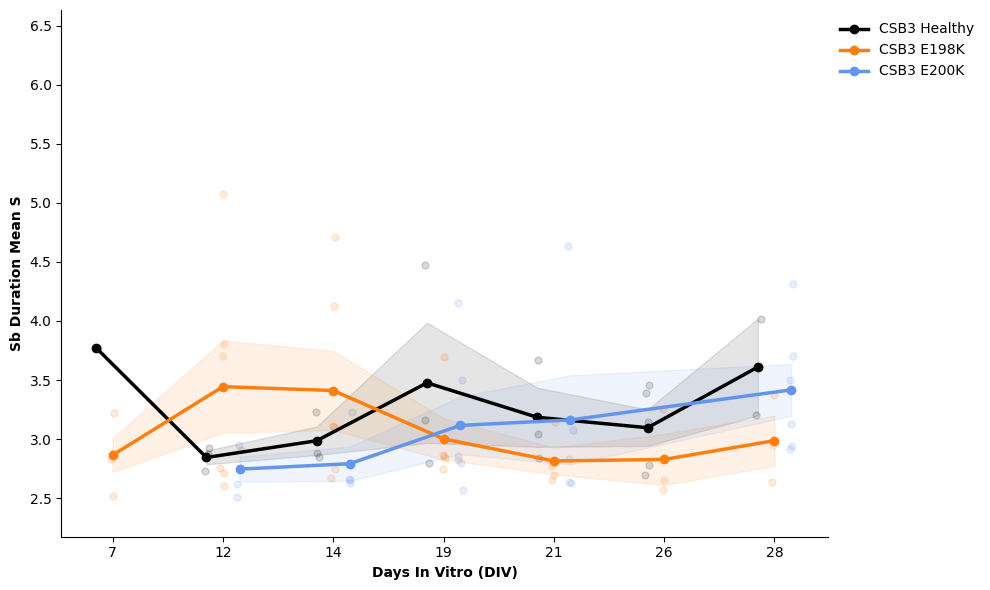

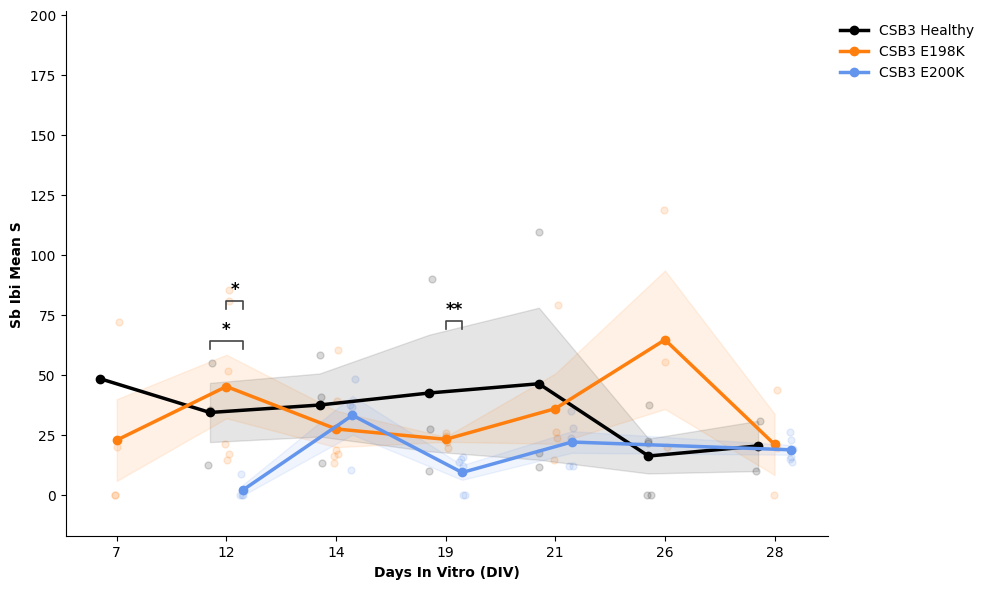

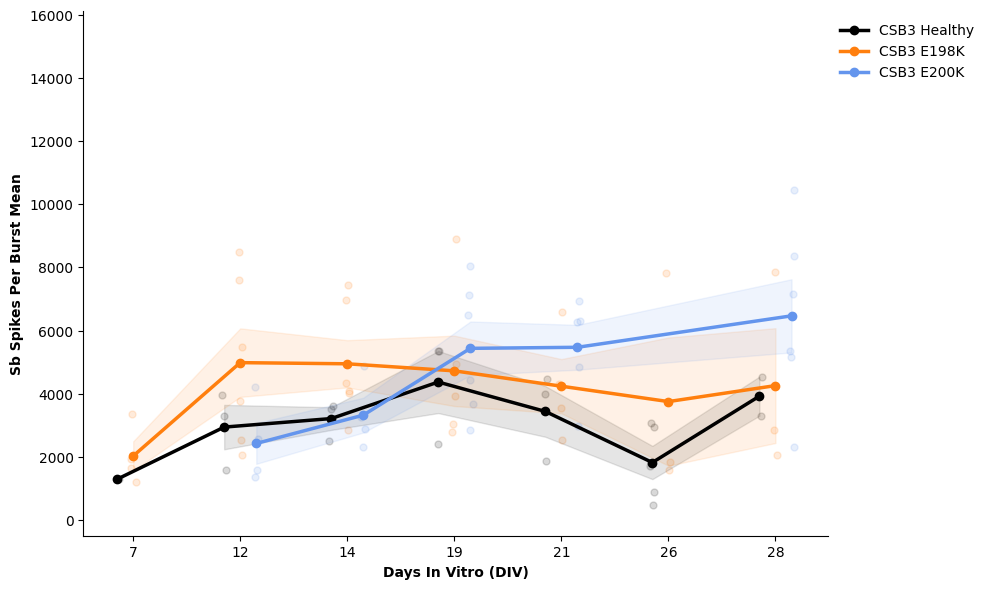

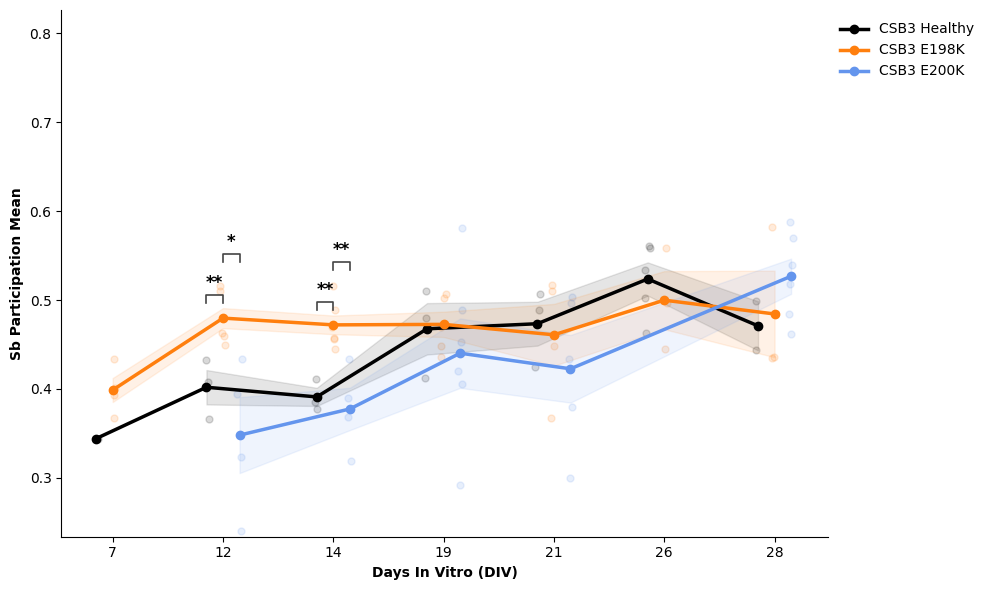

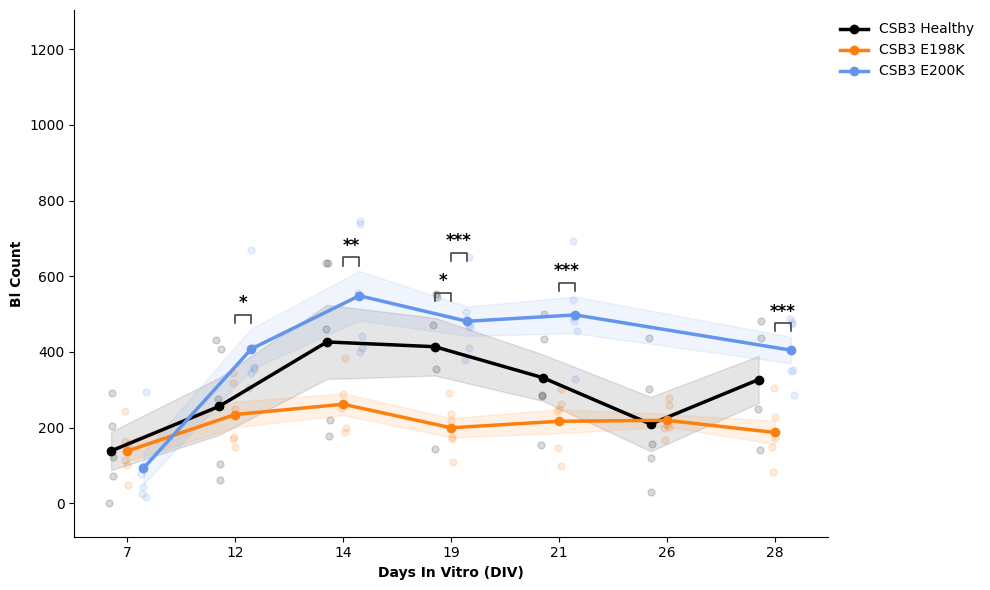

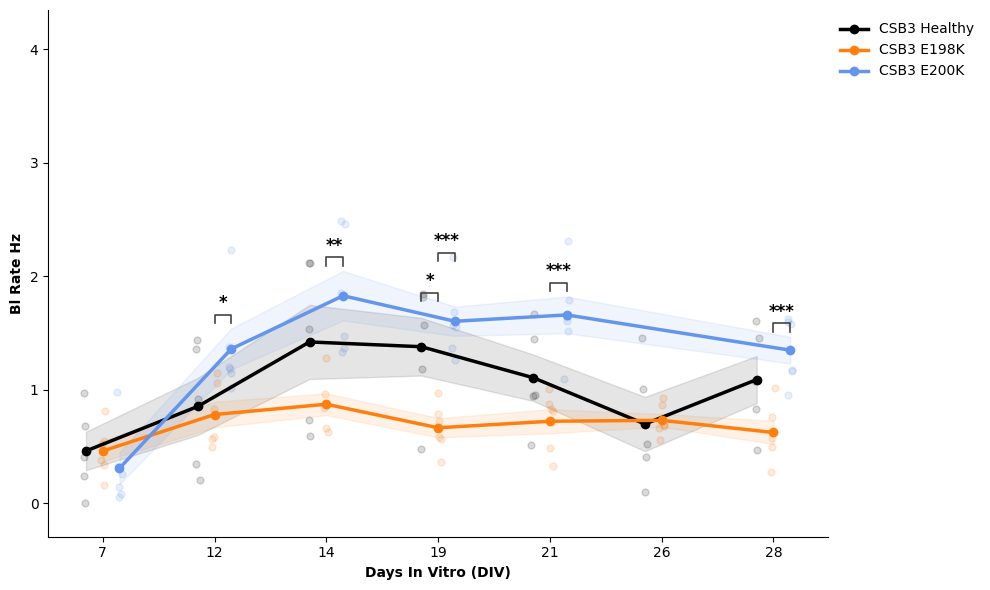

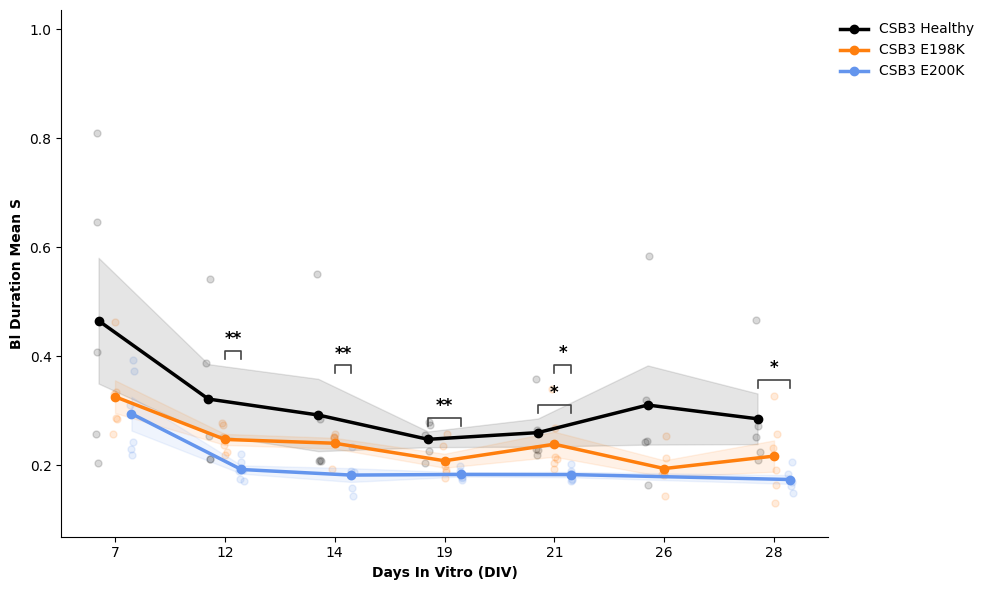

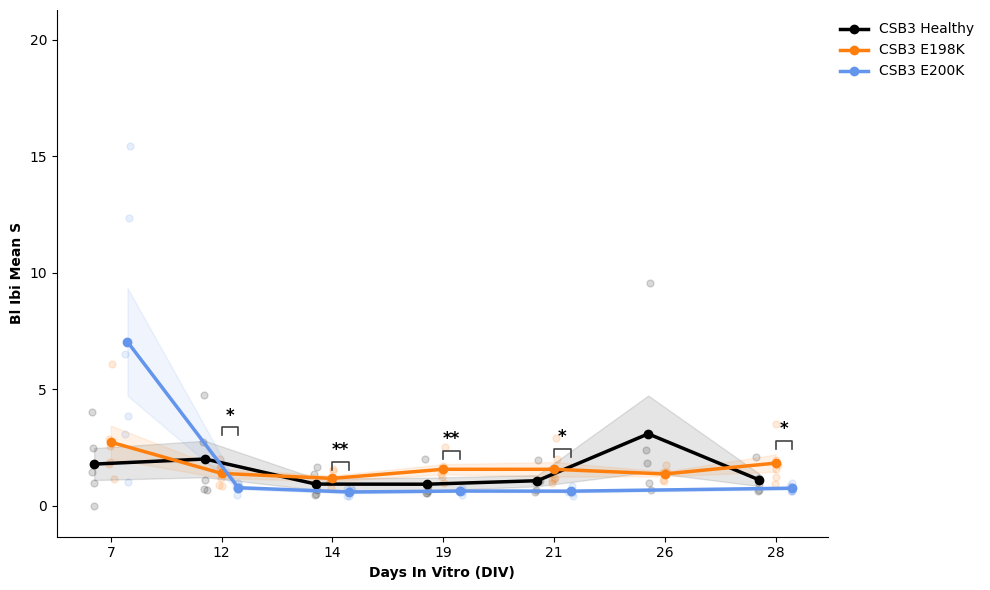

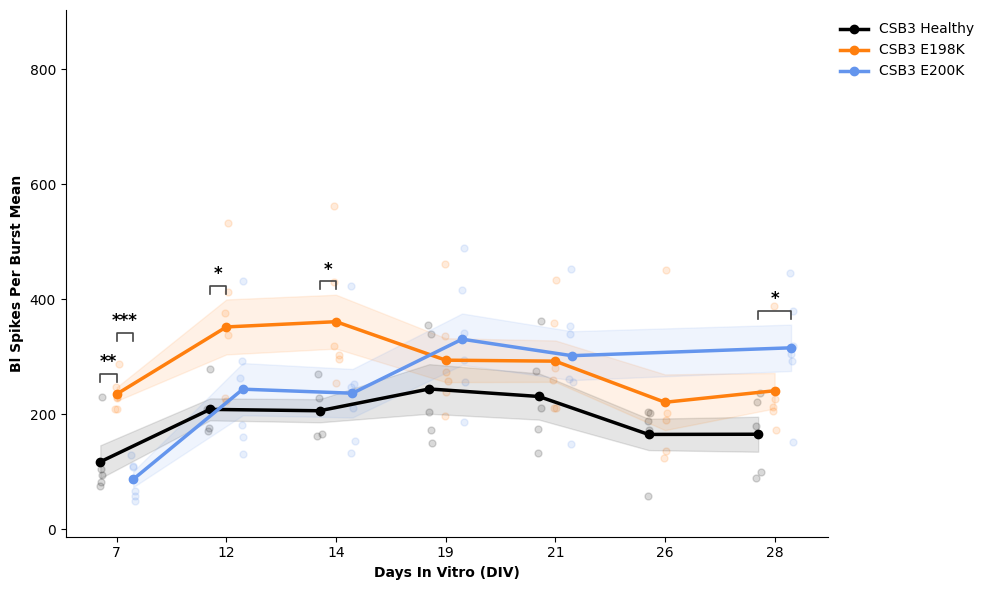

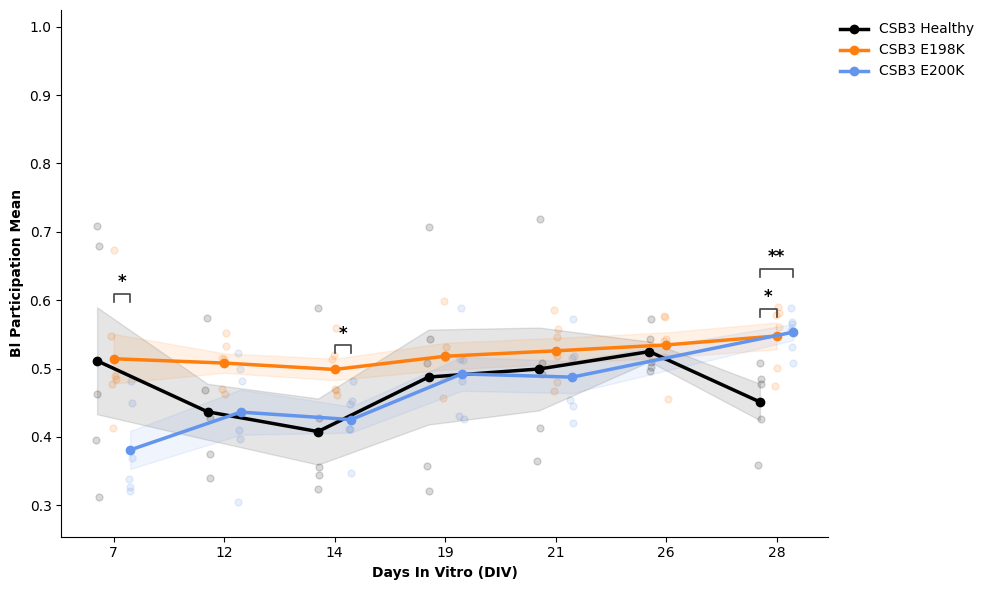

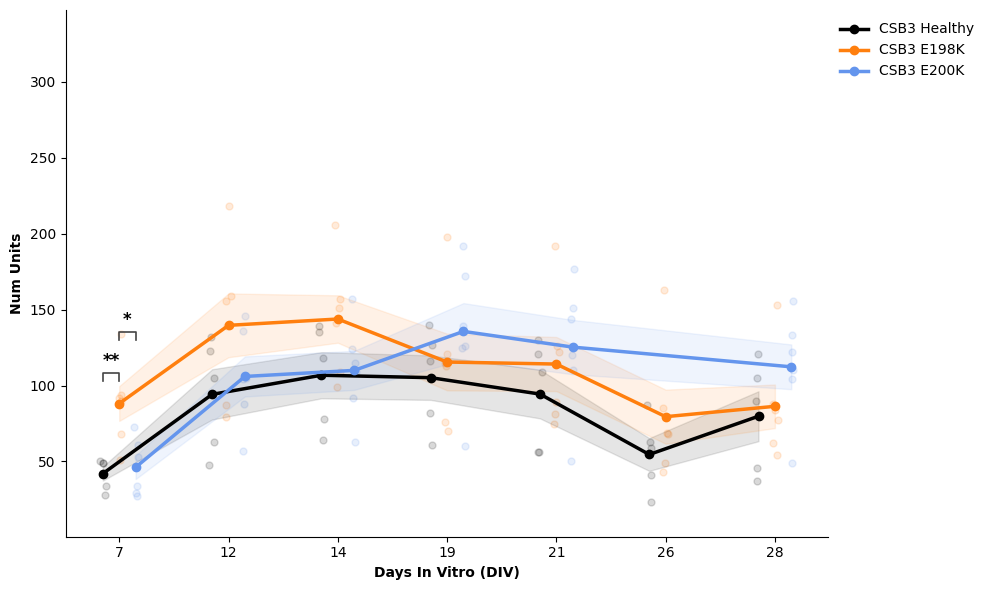

In [33]:
cols_to_plot = [ 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s','nb_fragment_count_mean',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
     'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
        'num_units'
       ]
for col in cols_to_plot:
    analyze_organoid_pairwise_final(
        neuronal_assay_df,
        value_col=col,
        feature_label=col.replace('_', ' ').title(),
        order=(  'CSB3 Healthy', 'CSB3 E198K','CSB3 E200K'),
        palette={ 'CSB3 Healthy': 'black','CSB3 E198K': '#ff7f0e', 'CSB3 E200K': 'cornflowerblue'},
        #save_path=f"/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/plots/{col}_lineplot.svg"
    )

In [25]:
from matplotlib.backends.backend_pdf import PdfPages

def export_all_to_pdf(df, cols, filename="MEA_Analysis_Report.pdf"):
    """
    Runs the pairwise analysis for all columns and saves them into a single PDF.
    """
    # Initialize the PDF document
    with PdfPages(filename) as pdf:
        for col in cols:
            print(f"Processing: {col}...")
            
            # 1. Generate the plot using our robust function
            # Note: We need to modify the function slightly to RETURN the fig
            fig = analyze_organoid_pairwise_final(
                df,
                value_col=col,
                feature_label=col.replace('_', ' ').title(),
                order=('Healthy', 'E198K', 'E200K'),
                palette={'Healthy': 'black', 'E198K': '#ff7f0e', 'E200K': 'cornflowerblue'}
            )
            
            # 2. If a figure was successfully created, save it to the PDF
            if fig is not None:
                pdf.savefig(fig)
                plt.close(fig) # Memory management: very important for 20+ plots
            
    print(f"\nSuccessfully exported all {len(cols)} features to {filename}")

# --- QUICK TWEAK TO YOUR FUNCTION ---
# Ensure your 'analyze_organoid_pairwise_final' ends with:
# return fig 
# instead of plt.show()

In [27]:
neuronal_assay_df.columns

Index(['Project', 'Date', 'ID', 'Run #', 'Well', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
       'nb_burst_peak_mean', 'nb_peak_synchrony_mean',
       'nb_fragment_count_mean', 'nb_durations_list', 'nb_peak_list',
       'nb_intensity_list', 'nb_synchrony_energy_list',
       'nb_fragment_count_list', 'sb_count', 'sb_rate_hz',
       'sb_duration_mean_s', 'sb_ibi_mean_s', 'sb_spikes_per_burst_mean',
       'sb_participation_mean', 'sb_durations_list', 'sb_peak_list',
       'sb_intensity_list', 'sb_synchrony_energy_list', 'bl_count',
       'bl_rate_hz', 'bl_duration_mean_s', 'bl_ibi_mean_s',
       'bl_spikes_per_burst_mean', 'bl_participation_mean',
       'bl_burst_peak_mean', 'bl_durations_list', 'bl_peak_list',
       'bl_intensity_list', 'bl_synchrony_energy_list', 'num_units',
       'sb_burst_peak_mean', 'sb_peak_synchrony_mean',
       'bl_peak_synchrony_mean', 'NeuronType'

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind, levene
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages

def analyze_organoid_pairwise_pdf_version(
    df, 
    value_col, 
    order=['Healthy','Healthy_PPP2RSD+', 'E198K','E198K_PPP2RSD+', 'E200K',
       'E200K_PPP2RSD+'],
    #order=['CSB3 Healthy', 'CSB3 E198K', 'CSB3 E200K'],
    #palette={'CSB3 Healthy': '#444444', 'CSB3 E198K': '#d98b5f', 'CSB3 E200K': '#8ca2ba'},
    palette= {'Healthy_PPP2RSD+': 'purple', 'Healthy': 'black', 'E198K_PPP2RSD+': 'purple', 'E198K': 'black',
       'E200K_PPP2RSD+': 'purple', 'E200K': 'black'},
    feature_label=None
):
    # 1. DATA PREP
    sub = df[df['NeuronType'].isin(order)].copy()
    sub = sub[['DIV', 'NeuronType', value_col]].dropna(subset=[value_col])
    
    if sub.empty:
        return None, None

    divs = sorted(sub['DIV'].unique())
    
    # 2. SUMMARY TABLE
    summary = sub.groupby(['DIV', 'NeuronType']).agg(
        mean=(value_col, 'mean'),
        sem=(value_col, lambda x: sem(x, nan_policy='omit')),
        n=(value_col, 'count')
    ).reindex(pd.MultiIndex.from_product([divs, order], names=['DIV', 'NeuronType'])).reset_index()

    # 3. PAIRWISE STATS
    stats_list = []
    pairs = list(combinations(order, 2))

    def get_stars(p):
        if p < 0.0001: return '****'
        if p < 0.001: return '***'
        if p < 0.01: return '**'
        if p < 0.05: return '*'
        return 'ns'

    for div in divs:
        day_data = sub[sub['DIV'] == div]
        for g1, g2 in pairs:
            v1 = day_data[day_data['NeuronType'] == g1][value_col].values
            v2 = day_data[day_data['NeuronType'] == g2][value_col].values
            if len(v1) >= 2 and len(v2) >= 2:
                _, p_lev = levene(v1, v2)
                equal_var = p_lev > 0.05
                test_type = "Student" if equal_var else "Welch"
                _, p = ttest_ind(v1, v2, equal_var=equal_var, nan_policy='omit')
                stats_list.append({'DIV': div, 'G1': g1, 'G2': g2, 'Comparison': f"{g1} vs {g2}",
                                   'p_raw': p, 'test_used': test_type, 'sig': get_stars(p)})
    stats_df = pd.DataFrame(stats_list)

    # 4. FIGURE: GROUPED BARS ACROSS DIVs
    fig_plot, ax = plt.subplots(figsize=(max(6, len(divs)*3), 6))
    
    n_groups = len(divs)
    n_bars = len(order)
    bar_width = 0.25
    group_spacing = 1.2  # Space between DIV clusters
    
    # Generate X positions
    indices = np.arange(n_groups) * group_spacing
    
    for i, nt in enumerate(order):
        # Filter summary for this genotype across all DIVs
        nt_summary = summary[summary['NeuronType'] == nt]
        x_offsets = indices + (i * bar_width)
        
        # Plot Bars
        ax.bar(x_offsets, nt_summary['mean'], width=bar_width, color=palette[nt], 
               alpha=0.6, edgecolor='black', linewidth=1, label=nt if i == 0 else "")
        
        # Plot Error Bars
        ax.errorbar(x_offsets, nt_summary['mean'], yerr=nt_summary['sem'], 
                    fmt='none', c='black', capsize=3, lw=1)
        
        # Plot Jittered Scatter for each DIV
        for j, div in enumerate(divs):
            points = sub[(sub['DIV'] == div) & (sub['NeuronType'] == nt)][value_col]
            jitter = (np.random.rand(len(points)) - 0.5) * (bar_width * 0.6)
            ax.scatter(np.full(len(points), x_offsets[j]) + jitter, points, 
                       color=palette[nt], edgecolor='black', alpha=0.4, s=20, zorder=3)

    # 5. STATISTICAL BRACKETS (Grouped per DIV)
    y_max_all = sub[value_col].max()
    yr = y_max_all * 0.1
    
    for j, div in enumerate(divs):
        div_x_start = indices[j]
        # Comparison 1: Healthy vs E198K
        comp1 = stats_df[(stats_df['DIV'] == div) & (stats_df['G1'] == order[0]) & (stats_df['G2'] == order[1])]
        if not comp1.empty and comp1['sig'].values[0] != 'ns':
            sig = comp1['sig'].values[0]
            x1, x2 = div_x_start, div_x_start + bar_width
            y = y_max_all + yr
            ax.plot([x1, x1, x2, x2], [y-(yr*0.2), y, y, y-(yr*0.2)], color='black', lw=1)
            ax.text((x1+x2)/2, y, sig, ha='center', va='bottom', fontsize=9, fontweight='bold')
            
        # Comparison 2: Healthy vs E200K
        comp2 = stats_df[(stats_df['DIV'] == div) & (stats_df['G1'] == order[0]) & (stats_df['G2'] == order[2])]
        if not comp2.empty and comp2['sig'].values[0] != 'ns':
            sig = comp2['sig'].values[0]
            x1, x2 = div_x_start, div_x_start + (2 * bar_width)
            y = y_max_all + (yr * 2.5)
            ax.plot([x1, x1, x2, x2], [y-(yr*0.2), y, y, y-(yr*0.2)], color='black', lw=1)
            ax.text((x1+x2)/2, y, sig, ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Formatting
    ax.set_xticks(indices + bar_width)
    ax.set_xticklabels([f"DIV {d}" for d in divs], fontweight='bold')
    ax.set_ylabel(feature_label or value_col, fontweight='bold')
    ax.set_title(feature_label, fontweight='bold', fontsize=14, pad=20)
    ax.spines[['top', 'right']].set_visible(False)
    
    # Legend with cleaned names
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([plt.Rectangle((0,0),1,1, color=palette[nt]) for nt in order], 
              [n.replace('CSB3 ', '') for n in order], frameon=False, loc='upper left', bbox_to_anchor=(1,1))

    plt.tight_layout()

    # 6. STATS TABLE PAGE
    fig_stats, ax_st = plt.subplots(figsize=(10, 8))
    ax_st.axis('off')
    if not stats_df.empty:
        display_stats = stats_df[['DIV', 'Comparison', 'p_raw', 'sig']].copy()
        display_stats['p_raw'] = display_stats['p_raw'].apply(lambda x: f"{x:.4e}" if pd.notnull(x) else "N/A")
        the_table = ax_st.table(cellText=display_stats.values, colLabels=display_stats.columns, loc='center', cellLoc='center')
        the_table.auto_set_font_size(False); the_table.set_fontsize(8); the_table.scale(1.2, 1.2)
    
    return fig_plot, fig_stats

def export_mea_analysis_to_pdf(df, cols,order,palette, output_name="MEA_Grouped_Report.pdf"):
    with PdfPages(output_name) as pdf:
        for col in cols:
            print(f"Plotting {col} across all DIVs...")
            label = col.replace('nb_', '').replace('_', ' ').title()
            fig_p, fig_s = analyze_organoid_pairwise_pdf_version(df, col, order=order, palette=palette, feature_label=label)
            if fig_p is not None:
                pdf.savefig(fig_p)
                pdf.savefig(fig_s)
                plt.close(fig_p)
                plt.close(fig_s)
    print(f"\nReport complete: {output_name}")

# --- EXECUTION ---
cols_to_plot = [
'num_units', 'bl_count', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_participation_mean',
       'nb_burst_peak_mean','nb_peak_synchrony_mean',
       'nb_fragment_count_mean'
]

export_mea_analysis_to_pdf(neuronal_assay_df, cols_to_plot,  order=(  'CSB3 Healthy', 'CSB3 E198K','CSB3 E200K'),
        palette={ 'CSB3 Healthy': 'black','CSB3 E198K': '#ff7f0e', 'CSB3 E200K': 'cornflowerblue'},
                           output_name='/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/MEA_Graphs_Grouped.pdf')

Plotting num_units across all DIVs...
Plotting bl_count across all DIVs...
Plotting nb_count across all DIVs...
Plotting nb_rate_hz across all DIVs...
Plotting nb_duration_mean_s across all DIVs...
Plotting nb_ibi_mean_s across all DIVs...
Plotting nb_spikes_per_burst_mean across all DIVs...
Plotting nb_participation_mean across all DIVs...
Plotting nb_burst_peak_mean across all DIVs...
Plotting nb_peak_synchrony_mean across all DIVs...
Plotting nb_fragment_count_mean across all DIVs...

Report complete: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/MEA_Graphs_Grouped.pdf


In [33]:
export_mea_analysis_to_pdf(neuronal_assay_df[neuronal_assay_df['DIV'] == 19], cols_to_plot,  order=(  'CSB3 Healthy', 'CSB3 E198K','CSB3 E200K'),
        palette={ 'CSB3 Healthy': 'black','CSB3 E198K': '#ff7f0e', 'CSB3 E200K': 'cornflowerblue'},
                           output_name='/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/MEA_Graphs_DIV19.pdf')

Plotting num_units across all DIVs...
Plotting bl_count across all DIVs...
Plotting nb_count across all DIVs...
Plotting nb_rate_hz across all DIVs...
Plotting nb_duration_mean_s across all DIVs...
Plotting nb_ibi_mean_s across all DIVs...
Plotting nb_spikes_per_burst_mean across all DIVs...
Plotting nb_participation_mean across all DIVs...
Plotting nb_burst_peak_mean across all DIVs...
Plotting nb_peak_synchrony_mean across all DIVs...
Plotting nb_fragment_count_mean across all DIVs...

Report complete: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/MEA_Graphs_DIV19.pdf


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages

def analyze_organoid_pairwise_pdf_version(
    df, 
    value_col, 
    group_col='NeuronType',
    order=['Healthy','Healthy_PPP2RSD+', 'E198K','E198K_PPP2RSD+', 'E200K','E200K_PPP2RSD+'],
    palette= {'Healthy': 'black', 'Healthy_PPP2RSD+': 'purple', 
              'E198K': 'black', 'E198K_PPP2RSD+': 'purple', 
              'E200K': 'black', 'E200K_PPP2RSD+': 'purple'},
    feature_label=None
):
    # 1. DATA PREP
    sub = df[df[group_col].isin(order)].copy()
    sub = sub.dropna(subset=[value_col])
    if sub.empty: 
        print(f"No data for {value_col}")
        return None, None, None

    divs = sorted(sub['DIV'].unique())
    
    # Statistics Helpers
    def get_stars(p):
        if p < 0.0001: return '****'
        if p < 0.001: return '***'
        if p < 0.01: return '**'
        if p < 0.05: return '*'
        return 'ns'

    def run_welch_stats(data_subset, g_col, v_col, pairs):
        results = []
        for g1, g2 in pairs:
            v1 = data_subset[data_subset[g_col] == g1][v_col].values
            v2 = data_subset[data_subset[g_col] == g2][v_col].values
            if len(v1) >= 2 and len(v2) >= 2:
                _, p = ttest_ind(v1, v2, equal_var=False, nan_policy='omit')
                results.append({'G1': g1, 'G2': g2, 'Comparison': f"{g1} vs {g2}", 
                                'p_raw': p, 'test_used': "Welch's T", 'sig': get_stars(p)})
        return pd.DataFrame(results)

    # 2. RUN STATISTICS
    pairs = list(combinations(order, 2))
    div_stats_list = []
    for div in divs:
        d_stats = run_welch_stats(sub[sub['DIV'] == div], group_col, value_col, pairs)
        if not d_stats.empty:
            d_stats['DIV'] = div
            div_stats_list.append(d_stats)
    
    stats_df = pd.concat(div_stats_list) if div_stats_list else pd.DataFrame()
    agg_stats_df = run_welch_stats(sub, group_col, value_col, pairs)

    # 3. FIGURE 1: GROUPED BARS ACROSS DIVs
    summary = sub.groupby(['DIV', group_col])[value_col].agg(['mean', lambda x: sem(x, nan_policy='omit')])
    summary.columns = ['mean', 'sem']
    summary = summary.reset_index()

    fig_div, ax = plt.subplots(figsize=(max(12, len(divs)*4.5), 8))
    group_spacing = 3.0 
    bar_width = 0.32
    indices = np.arange(len(divs)) * group_spacing
    
    y_max_global = sub[value_col].max()
    yr = y_max_global * 0.12

    for i, nt in enumerate(order):
        nt_summary = summary[summary[group_col] == nt].set_index('DIV').reindex(divs).reset_index()
        x_off = indices + (i * bar_width)
        
        ax.bar(x_off, nt_summary['mean'], width=bar_width, color=palette.get(nt, 'gray'), 
               alpha=0.6, edgecolor='black', linewidth=1.2)
        ax.errorbar(x_off, nt_summary['mean'], yerr=nt_summary['sem'], fmt='none', c='black', capsize=3)
        
        # GENOTYPE SUB-LABELS
        if i % 2 == 0:
            geno_text = nt.replace('_PPP2RSD+', '')
            for j, idx in enumerate(indices):
                ax.text(idx + (i * bar_width) + bar_width/2, -y_max_global*0.06, 
                        geno_text, ha='center', va='top', fontsize=9, fontweight='bold')

        for j, div in enumerate(divs):
            pts = sub[(sub['DIV'] == div) & (sub[group_col] == nt)][value_col]
            jitter = (np.random.rand(len(pts)) - 0.5) * (bar_width * 0.5)
            ax.scatter(np.full(len(pts), x_off[j]) + jitter, pts, color=palette.get(nt, 'gray'), 
                       edgecolor='white', alpha=0.4, s=15, zorder=3)

    # Brackets
    for j, div in enumerate(divs):
        div_x = indices[j]
        d_stats = stats_df[stats_df['DIV'] == div] if not stats_df.empty else pd.DataFrame()
        if d_stats.empty: continue

        def draw_b(idx1, idx2, y_lvl):
            p_stats = d_stats[((d_stats['G1'] == order[idx1]) & (d_stats['G2'] == order[idx2]))]
            if not p_stats.empty and p_stats['sig'].values[0] != 'ns':
                sig = p_stats['sig'].values[0]
                x1, x2 = div_x + (idx1 * bar_width), div_x + (idx2 * bar_width)
                y = y_max_global + (y_lvl * yr)
                ax.plot([x1, x1, x2, x2], [y-(yr*0.2), y, y, y-(yr*0.2)], color='black', lw=1)
                ax.text((x1+x2)/2, y, sig, ha='center', va='bottom', fontsize=8, fontweight='bold')

        draw_b(0, 1, 0.5); draw_b(2, 3, 0.5); draw_b(4, 5, 0.5)
        draw_b(0, 2, 1.8); draw_b(2, 4, 1.8); draw_b(0, 4, 3.8)
        draw_b(1, 3, 2.8); draw_b(3, 5, 2.8); draw_b(1, 5, 4.8)

    ax.set_xticks(indices + (bar_width * 2.5))
    ax.set_xticklabels([f"DIV {int(d)}" for d in divs], fontweight='bold', fontsize=12)
    # Correct way to add padding to tick labels
    ax.tick_params(axis='x', which='major', pad=35) 
    
    ax.set_ylabel(feature_label, fontweight='bold')
    ax.set_title(f"{feature_label} per DIV (Paired NT/AAV Comparison)", fontweight='bold', pad=35)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_ylim(0, y_max_global + (yr * 7))
    
    legend_elements = [plt.Rectangle((0,0),1,1, color='black', alpha=0.6, label='NT (No Treatment)'),
                       plt.Rectangle((0,0),1,1, color='purple', alpha=0.6, label='AAV (PPP2RSD+)')]
    ax.legend(handles=legend_elements, frameon=False, loc='upper left', bbox_to_anchor=(1,1))

    # 4. FIGURE 2: AGGREGATED
    agg_summary = sub.groupby(group_col)[value_col].agg(['mean', lambda x: sem(x, nan_policy='omit')])
    agg_summary.columns = ['mean', 'sem']
    agg_summary = agg_summary.reindex(order).reset_index()

    fig_agg, ax_agg = plt.subplots(figsize=(7, 7))
    for i, nt in enumerate(order):
        row = agg_summary.iloc[i]
        pts = sub[sub[group_col] == nt][value_col]
        ax_agg.bar(i, row['mean'], width=0.7, color=palette.get(nt, 'gray'), alpha=0.6, edgecolor='black')
        ax_agg.errorbar(i, row['mean'], yerr=row['sem'], fmt='none', c='black', capsize=5)
        ax_agg.scatter(np.full(len(pts), i) + (np.random.rand(len(pts))-0.5)*0.4, pts, 
                       color=palette.get(nt, 'gray'), edgecolor='white', alpha=0.4, s=20, zorder=3)

    for idx1, idx2, y_lvl in [(0,1,0.5), (2,3,0.5), (4,5,0.5), (0,2,1.8), (2,4,1.8), (0,4,3.8)]:
        sig_row = agg_stats_df[(agg_stats_df['G1'] == order[idx1]) & (agg_stats_df['G2'] == order[idx2])]
        if not sig_row.empty and sig_row['sig'].values[0] != 'ns':
            y = y_max_global + (yr * y_lvl)
            ax_agg.plot([idx1, idx1, idx2, idx2], [y-(yr*0.2), y, y, y-(yr*0.2)], color='black', lw=1)
            ax_agg.text((idx1+idx2)/2, y, sig_row['sig'].values[0], ha='center', va='bottom', fontweight='bold')

    ax_agg.set_xticks(range(len(order)))
    ax_agg.set_xticklabels([n.replace('_PPP2RSD+', '+') for n in order], rotation=45, fontweight='bold')
    ax_agg.set_ylabel(feature_label, fontweight='bold')
    ax_agg.set_title(f"{feature_label} (Aggregated)", fontweight='bold', pad=25)
    ax_agg.spines[['top', 'right']].set_visible(False)
    ax_agg.set_ylim(0, y_max_global + (yr * 7))

    # 5. FIGURE 3: STATS TABLE
    fig_tbl, ax_tbl = plt.subplots(figsize=(10, 10))
    ax_tbl.axis('off')
    if not stats_df.empty:
        agg_tbl = agg_stats_df.copy(); agg_tbl['DIV'] = 'AGGREGATED'
        full_stats = pd.concat([stats_df, agg_tbl])[['DIV', 'Comparison', 'p_raw', 'sig']]
        full_stats['p_raw'] = full_stats['p_raw'].apply(lambda x: f"{x:.4e}" if pd.notnull(x) else "N/A")
        table = ax_tbl.table(cellText=full_stats.values, colLabels=full_stats.columns, loc='center', cellLoc='center')
        table.auto_set_font_size(False); table.set_fontsize(7); table.scale(1.1, 1.1)
        #ax_tbl.set_title(f"Detailed Statistics Table: {feature_label}", fontweight='bold')

    plt.tight_layout()
    return fig_div, fig_agg, fig_tbl

def export_mea_analysis_to_pdf(df, cols, output_name="Report.pdf"):
    with PdfPages(output_name) as pdf:
        for col in cols:
            if col not in df.columns: continue
            print(f"Processing Analysis: {col}")
            label = col.replace('nb_', '').replace('_', ' ').title()
            f1, f2, f3 = analyze_organoid_pairwise_pdf_version(df, col, feature_label=label)
            if f1 is not None:
                pdf.savefig(f1); pdf.savefig(f2); pdf.savefig(f3)
                plt.close(f1); plt.close(f2); plt.close(f3)
    print(f"\nCompleted! PDF saved: {output_name}")

# --- EXECUTION ---
cols_to_plot = ['nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_spikes_per_burst_mean', 'num_units', 'bl_count', 'nb_burst_peak_mean']
export_mea_analysis_to_pdf(neuronal_assay_df, cols_to_plot, 
                           output_name='/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_COB7_080825_VD/MEA_Graphs_Final_Paired_Labeled.pdf')

Processing Analysis: nb_count


/tmp/ipykernel_1192715/2533464583.py:164: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Processing Analysis: nb_rate_hz


/tmp/ipykernel_1192715/2533464583.py:164: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Processing Analysis: nb_duration_mean_s


/tmp/ipykernel_1192715/2533464583.py:164: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Processing Analysis: nb_spikes_per_burst_mean


/tmp/ipykernel_1192715/2533464583.py:164: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Processing Analysis: num_units


/tmp/ipykernel_1192715/2533464583.py:164: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Processing Analysis: bl_count


/tmp/ipykernel_1192715/2533464583.py:164: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Processing Analysis: nb_burst_peak_mean
No data for nb_burst_peak_mean

Completed! PDF saved: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_COB7_080825_VD/MEA_Graphs_Final_Paired_Labeled.pdf


In [29]:
neuronal_assay_df.head()

,Project,Date,ID,Run #,Well,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,...,bl_participation_mean,bl_burst_peak_mean,bl_durations_list,bl_peak_list,bl_intensity_list,bl_synchrony_energy_list,num_units,NeuronType,Assay,DIV
77,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well000,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,28.0,0.093465,0.588214,10.348889,...,0.481481,NaN,"[0.3000000000000007, 0.4200000000000017, 0.450...","[5.2476917665725225, 6.862817079551998, 5.8010...","[55, 91, 96, 63, 76, 88, 68, 72, 38, 52, 71, 7...","[1.1823018811070998, 1.8553284956307556, 2.407...",27,CSB3 E200K,Neuronal Units 9,7
78,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well001,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,39.0,0.129986,0.612308,7.836316,...,0.449172,NaN,"[0.3899999999999997, 0.17999999999999972, 0.20...","[10.96627712073074, 12.976180434227798, 17.183...","[152, 81, 147, 77, 79, 80, 113, 150, 102, 112,...","[2.8859639443734757, 2.1993284629264, 3.042084...",53,CSB3 E200K,Neuronal Units 9,7
76,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well002,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,137.0,0.456626,0.498531,2.175400,...,0.327183,NaN,"[0.23359999999968306, 0.3503999999995244, 0.32...","[11.65016649671894, 12.143127482933279, 10.630...","[115, 143, 131, 100, 80, 154, 188, 88, 73, 53,...","[2.460674305598296, 3.4175974052200297, 2.6928...",73,CSB3 E200K,Neuronal Units 9,7
75,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well003,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,44.0,0.146660,0.388500,6.787607,...,0.337662,NaN,"[0.36260000000009995, 0.18130000000004998, 0.1...","[5.7299310733083235, 5.1558524674546335, 5.868...","[64, 32, 43, 81, 37, 40, 30, 59, 51, 45, 36, 4...","[1.4011445141446062, 0.6922616525969291, 0.734...",29,CSB3 E200K,Neuronal Units 9,7
79,JGA_CSB3_010825_VD,2025-01-15,M05506,000009,well004,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...,14.0,0.046667,0.505714,20.162308,...,0.368852,NaN,"[0.41999999999999993, 0.5700000000000003, 0.24...","[11.67843413313554, 12.621342730901826, 10.663...","[143, 210, 93, 120, 169, 63, 174, 57, 114, 226...","[3.1777784465503527, 4.673072637484475, 2.3089...",61,CSB3 E200K,Neuronal Units 9,7


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages

def analyze_organoid_pairwise_pdf_version(
    df, 
    value_col, 
    group_col='NeuronType',
    order=['CSB3 Healthy', 'CSB3 E198K', 'CSB3 E200K'],
    palette={'CSB3 Healthy': '#444444', 'CSB3 E198K': '#d98b5f', 'CSB3 E200K': '#8ca2ba'},
    feature_label=None
):
    # 1. DATA PREP
    # Filter for genotypes in order and drop NaNs
    sub = df[df[group_col].isin(order)].copy()
    sub = sub.dropna(subset=[value_col])
    
    if sub.empty:
        print(f"No data for {value_col}")
        return None, None, None

    divs = sorted(sub['DIV'].unique())
    
    # --- STATISTICS UTILITY (Strictly Welch's) ---
    def get_stars(p):
        if p < 0.0001: return '****'
        if p < 0.001: return '***'
        if p < 0.01: return '**'
        if p < 0.05: return '*'
        return 'ns'

    def run_welch_stats(data_subset, g_col, v_col, pairs):
        results = []
        for g1, g2 in pairs:
            v1 = data_subset[data_subset[g_col] == g1][v_col].values
            v2 = data_subset[data_subset[g_col] == g2][v_col].values
            if len(v1) >= 2 and len(v2) >= 2:
                # Independent t-test with Welch's correction
                _, p = ttest_ind(v1, v2, equal_var=False, nan_policy='omit')
                results.append({
                    'G1': g1, 'G2': g2, 'Comparison': f"{g1} vs {g2}", 
                    'p_raw': p, 'test_used': "Welch's T", 'sig': get_stars(p)
                })
        return pd.DataFrame(results)

    # 2. RUN STATISTICS
    pairs = list(combinations(order, 2))
    div_stats_list = []
    for div in divs:
        d_stats = run_welch_stats(sub[sub['DIV'] == div], group_col, value_col, pairs)
        if not d_stats.empty:
            d_stats['DIV'] = div
            div_stats_list.append(d_stats)
    
    stats_df = pd.concat(div_stats_list) if div_stats_list else pd.DataFrame()
    agg_stats_df = run_welch_stats(sub, group_col, value_col, pairs)

    # 3. FIGURE 1: GROUPED BARS ACROSS DIVs + SIGNIFICANCE
    summary = sub.groupby(['DIV', group_col])[value_col].agg(['mean', lambda x: sem(x, nan_policy='omit')])
    summary.columns = ['mean', 'sem']
    summary = summary.reset_index()

    fig_div, ax = plt.subplots(figsize=(max(8, len(divs)*3), 7))
    indices = np.arange(len(divs)) * 2.0 # Extra spacing for brackets
    bar_width = 0.4

    y_max_global = sub[value_col].max()
    yr = y_max_global * 0.12 # Vertical spacing unit for brackets

    for i, nt in enumerate(order):
        nt_summary = summary[summary[group_col] == nt].set_index('DIV').reindex(divs).reset_index()
        x_off = indices + (i * bar_width)
        
        # Plot Bars
        ax.bar(x_off, nt_summary['mean'], width=bar_width, color=palette.get(nt, 'gray'), 
               alpha=0.6, edgecolor='black', label=nt.replace('CSB3 ', ''))
        ax.errorbar(x_off, nt_summary['mean'], yerr=nt_summary['sem'], fmt='none', c='black', capsize=3)
        
        # Plot Jittered points
        for j, div in enumerate(divs):
            pts = sub[(sub['DIV'] == div) & (sub[group_col] == nt)][value_col]
            jitter = (np.random.rand(len(pts)) - 0.5) * (bar_width * 0.4)
            ax.scatter(np.full(len(pts), x_off[j]) + jitter, pts, color=palette.get(nt, 'gray'), 
                       edgecolor='black', alpha=0.3, s=15, zorder=3)

    # Draw Per-DIV significance bars
    for j, div in enumerate(divs):
        div_x_base = indices[j]
        day_stats = stats_df[stats_df['DIV'] == div] if not stats_df.empty else pd.DataFrame()
        if day_stats.empty: continue
        
        # Comparison 1: Healthy vs E198K
        s1 = day_stats[(day_stats['G1'] == order[0]) & (day_stats['G2'] == order[1])]
        if not s1.empty and s1['sig'].values[0] != 'ns':
            y = y_max_global + yr
            x1, x2 = div_x_base, div_x_base + bar_width
            ax.plot([x1, x1, x2, x2], [y-(yr*0.2), y, y, y-(yr*0.2)], color='black', lw=1)
            ax.text((x1+x2)/2, y, s1['sig'].values[0], ha='center', va='bottom', fontsize=9, fontweight='bold')
            
        # Comparison 2: Healthy vs E200K
        s2 = day_stats[(day_stats['G1'] == order[0]) & (day_stats['G2'] == order[2])]
        if not s2.empty and s2['sig'].values[0] != 'ns':
            y = y_max_global + (yr * 2.5)
            x1, x2 = div_x_base, div_x_base + (2 * bar_width)
            ax.plot([x1, x1, x2, x2], [y-(yr*0.2), y, y, y-(yr*0.2)], color='black', lw=1)
            ax.text((x1+x2)/2, y, s2['sig'].values[0], ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(indices + bar_width)
    ax.set_xticklabels([f"DIV {int(d)}" for d in divs], fontweight='bold')
    ax.set_ylabel(feature_label, fontweight='bold')
    ax.set_title(f"{feature_label} per DIV (Welch's T-test)", fontweight='bold', pad=25)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_ylim(0, y_max_global + (yr * 6))
    ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

    # 4. FIGURE 2: AGGREGATED PLOT
    agg_summary = sub.groupby(group_col)[value_col].agg(['mean', lambda x: sem(x, nan_policy='omit')])
    agg_summary.columns = ['mean', 'sem']
    agg_summary = agg_summary.reindex(order).reset_index()

    fig_agg, ax_agg = plt.subplots(figsize=(5, 6))
    for i, nt in enumerate(order):
        row = agg_summary.iloc[i]
        pts = sub[sub[group_col] == nt][value_col]
        ax_agg.bar(i, row['mean'], width=0.7, color=palette.get(nt, 'gray'), alpha=0.6, edgecolor='black')
        ax_agg.errorbar(i, row['mean'], yerr=row['sem'], fmt='none', c='black', capsize=5)
        ax_agg.scatter(np.full(len(pts), i) + (np.random.rand(len(pts))-0.5)*0.4, pts, 
                       color=palette.get(nt, 'gray'), edgecolor='black', alpha=0.3, s=20, zorder=3)

    # Brackets for Aggregated
    for i, (target_geno, y_lvl) in enumerate([(order[1], 1), (order[2], 2.5)]):
        sig_row = agg_stats_df[(agg_stats_df['G1'] == order[0]) & (agg_stats_df['G2'] == target_geno)]
        if not sig_row.empty and sig_row['sig'].values[0] != 'ns':
            y = y_max_global + (yr * y_lvl)
            x1, x2 = 0, order.index(target_geno)
            ax_agg.plot([x1, x1, x2, x2], [y-(yr*0.2), y, y, y-(yr*0.2)], color='black', lw=1.2)
            ax_agg.text((x1+x2)/2, y, sig_row['sig'].values[0], ha='center', va='bottom', fontweight='bold')

    ax_agg.set_xticks(range(len(order)))
    ax_agg.set_xticklabels([n.replace('CSB3 ', '') for n in order], fontweight='bold')
    ax_agg.set_ylabel(feature_label, fontweight='bold')
    ax_agg.set_title(f"{feature_label} (Aggregated)", fontweight='bold', pad=25)
    ax_agg.spines[['top', 'right']].set_visible(False)
    ax_agg.set_ylim(0, y_max_global + (yr * 6))

    # 5. FIGURE 3: STATS TABLE
    fig_tbl, ax_tbl = plt.subplots(figsize=(10, 8))
    ax_tbl.axis('off')
    if not stats_df.empty or not agg_stats_df.empty:
        agg_tbl = agg_stats_df.copy(); agg_tbl['DIV'] = 'AGGREGATED'
        full_stats = pd.concat([stats_df, agg_tbl])[['DIV', 'Comparison', 'test_used', 'p_raw', 'sig']]
        full_stats['p_raw'] = full_stats['p_raw'].apply(lambda x: f"{x:.4e}" if pd.notnull(x) else "N/A")
        
        table = ax_tbl.table(cellText=full_stats.values, colLabels=full_stats.columns, loc='center', cellLoc='center')
        table.auto_set_font_size(False); table.set_fontsize(8); table.scale(1.2, 1.2)
        ax_tbl.set_title(f"Statistical Summary Table: {feature_label}", fontweight='bold')

    plt.tight_layout()
    return fig_div, fig_agg, fig_tbl

def export_mea_analysis_to_pdf(df, cols, output_name="Report.pdf"):
    with PdfPages(output_name) as pdf:
        for col in cols:
            if col not in df.columns: continue
            print(f"Generating full analysis for: {col}")
            label = col.replace('nb_', '').replace('_', ' ').title()
            f1, f2, f3 = analyze_organoid_pairwise_pdf_version(df, col, feature_label=label)
            if f1 is not None:
                pdf.savefig(f1); pdf.savefig(f2); pdf.savefig(f3)
                plt.close(f1); plt.close(f2); plt.close(f3)
    print(f"\nPDF Report Saved: {output_name}")

# --- EXECUTION ---
# Using Welch's T-test for a robust biological comparison
export_mea_analysis_to_pdf(
    neuronal_assay_df, 
    ['nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_spikes_per_burst_mean', 'num_units', 'bl_count', 'nb_burst_peak_mean', 'nb_peak_synchrony_mean'    ], 
    output_name='/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/MEA_Graphs_DIV19.pdf'
)

Generating full analysis for: nb_count
Generating full analysis for: nb_rate_hz
Generating full analysis for: nb_duration_mean_s
Generating full analysis for: nb_spikes_per_burst_mean
Generating full analysis for: num_units
Generating full analysis for: bl_count
Generating full analysis for: nb_burst_peak_mean
Generating full analysis for: nb_peak_synchrony_mean

PDF Report Saved: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/MEA_Graphs_DIV19.pdf


## Graphs ylim CUTOOF